# A base de dados

### Carregando o dataset

In [2]:
import pandas as pd

dados = pd.read_csv('dados/Bicicletas.csv')

### Conhecendo a base de dados

In [3]:
dados.head()

,clima,temperatura,bicicletas_alugadas
0,2,0.363625,985
1,2,0.353739,801
2,1,0.189405,1349
3,1,0.212122,1562
4,1,0.229270,1600


In [4]:
dados.shape

(731, 3)

In [5]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'temperatura')

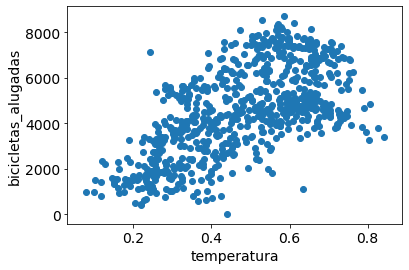

In [6]:
plt.rcParams.update({'font.size': 14})
plt.scatter(dados['temperatura'],dados['bicicletas_alugadas'])
plt.ylabel('bicicletas_alugadas')
plt.xlabel('temperatura')

([<matplotlib.axis.XTick at 0x15aa6f4b508>,
 <a list of 3 Text xticklabel objects>)

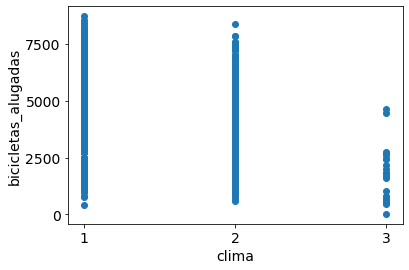

In [7]:
plt.scatter(dados['clima'],dados['bicicletas_alugadas'])
plt.ylabel('bicicletas_alugadas')
plt.xlabel('clima')
plt.rcParams.update({'font.size': 22})
indice=[1,2,3]
plt.xticks(indice, fontsize=14)

### Normalizando a base de dados

In [8]:
import numpy as np

In [9]:
y = dados['bicicletas_alugadas'].values

In [10]:
X = dados[['clima','temperatura']].values
print(X)

[[2.       0.363625]
 [2.       0.353739]
 [1.       0.189405]
 ...
 [2.       0.2424  ]
 [1.       0.2317  ]
 [2.       0.223487]]


In [11]:
X = X/np.amax(X,axis=0)
print(X)

[[0.66666667 0.43242565]
 [0.66666667 0.42066914]
 [0.33333333 0.22524188]
 ...
 [0.66666667 0.28826395]
 [0.33333333 0.27553942]
 [0.66666667 0.26577246]]


In [12]:
ymax=np.amax(y)
y = y/ymax
print(y[0:10])

[0.11303649 0.09192105 0.15480835 0.17925178 0.18361258 0.18430112
 0.17328437 0.11005279 0.09433096 0.15159513]


### Funções de ativação

In [13]:
def sigmoid(Soma):
    return 1/(1+np.exp(-Soma))

def relu(Soma):
    return np.maximum(0,Soma)

### Criando a estrutura da rede

### Pesos e viés

In [15]:
def inicia_camadas(arquitetura, seed = 99):
    # inicia os valores aleatórios
    np.random.seed(seed)
    # numero de camadas da rede neural
    numero_de_camadas = len(arquitetura)
    # inicia armazenamento de parametros
    valores_parametros = {}
    
    # itera nas camadas da rede
    for indice, camada in enumerate(arquitetura):
        
        indice_camada = indice + 1
        
        # extrai o numero de nodos nas camadas
        tamanho_camada_entrada = camada["dim_entrada"]
        tamanho_camada_saida = camada["dim_saida"]
        
        # inicia os valores na matriz de pesos P
        # e o vetor de viés ou bias b
        valores_parametros['P' + str(indice_camada)] = np.random.randn(
            tamanho_camada_saida, tamanho_camada_entrada)  * 0.1
        valores_parametros['b' + str(indice_camada)] = np.random.randn(
            tamanho_camada_saida, 1) * 0.1
        
    return valores_parametros

### Propagação da rede

In [16]:
def propaga_uma_camada(Ativado_anterior, Pesos_atual, b_atual, ativacao="relu"):
    # cálculo da entrada para a função de ativação
    Saida_atual = np.dot(Pesos_atual, Ativado_anterior) + b_atual
    
    # selecção da função de ativação
    if ativacao is "relu":
        func_ativacao = relu
    elif ativacao is "sigmoid":
        func_ativacao = sigmoid
    else:
        raise Exception('Ainda não implementamos essa funcao')
        
    # retorna a ativação calculada Ativado_atual e a matriz intermediária Saida
    return func_ativacao(Saida_atual), Saida_atual

In [17]:
def propaga_total(X, valores_parametros, arquitetura):
    # memoria temporaria para a retropropagacao
    memoria = {}
    # O vetor X é a ativação para a camada 0 
    Ativado_atual = X
    
    # iterações para as camadas
    for indice, camada in enumerate(arquitetura):
        # a numeração das camadas começa de 1
        indice_camada = indice + 1
        # utiliza a ativação da iteração anterior
        Ativado_anterior = Ativado_atual
        
        # extrai a função de ativação para a camada atual
        func_ativacao_atual = camada["ativacao"]
        # extrai os pesos da camada atual
        Pesos_atual = valores_parametros["P" + str(indice_camada)]
        # extrai o bias para a camada atual
        b_atual = valores_parametros["b" + str(indice_camada)]
        # cálculo da ativação para a camada atual
        Ativado_atual, Saida_atual = propaga_uma_camada(Ativado_anterior, Pesos_atual, b_atual, func_ativacao_atual)
        
        # salca os valores calculados na memória
        memoria["A" + str(indice)] = Ativado_anterior
        memoria["Z" + str(indice_camada)] = Saida_atual
       
    # retorna o vetor predito e um dicionário contendo os valores intermediários
    return Ativado_atual, memoria

### Testando a rede

In [18]:
valores_parametros = inicia_camadas(arquitetura, seed = 99)
y_estimado, memoria = propaga_total(np.transpose(X), valores_parametros, arquitetura)

In [19]:
y_estimado[0,0]*ymax

4579.982967258466

In [20]:
y[0]*ymax

985.0000000000001

### Atualização dos pesos

In [21]:
def atualiza(valores_parametros, gradidentes, arquitetura, taxa_aprendizagem):

    # iterações pelas camadas
    for indice_camada, camada in enumerate(arquitetura, 1):
        valores_parametros["P" + str(indice_camada)] -= taxa_aprendizagem * gradidentes["dP" + str(indice_camada)]        
        valores_parametros["b" + str(indice_camada)] -= taxa_aprendizagem * gradidentes["db" + str(indice_camada)]

    return valores_parametros;

### Função de custo

In [22]:
def valor_de_custo(Y_predito, Y):
    # numero_de_exemplos
    m = Y_predito.shape[1]
    
    custo = -1 / m * (np.dot(Y, np.log(Y_predito).T) + np.dot(1 - Y, np.log(1 - Y_predito).T))
    return np.squeeze(custo)

### Retropropagação

In [24]:
def retropropagacao_total(Y_predito, Y, memoria, valores_parametros, arquitetura):
   
    gradientes = {}
    
    # numero de exemplos
    #m = Y.shape[1]
    # para garantir que os dois vetores tenham a mesma dimensão
    Y = Y.reshape(Y_predito.shape)
    
    # inicia o algoritmo de gradiente descendente
    dAtivado_anterior = - (np.divide(Y, Y_predito) - np.divide(1 - Y, 1 - Y_predito));
    
    for indice_camada_anterior, camada in reversed(list(enumerate(arquitetura))):
        
        indice_camada_atual = indice_camada_anterior + 1
        # Função de ativação para a camada atual
        
        funcao_ativao_atual = camada["ativacao"]
        
        dAtivado_atual = dAtivado_anterior
        
        Ativado_anterior = memoria["A" + str(indice_camada_anterior)]
        Saida_atual = memoria["Z" + str(indice_camada_atual)]
        
        Pesos_atual = valores_parametros["P" + str(indice_camada_atual)]
        b_atual = valores_parametros["b" + str(indice_camada_atual)]
        
        dAtivado_anterior, dPesos_atual, db_atual = retropropagacao_uma_camada(
            dAtivado_atual, Pesos_atual, b_atual, Saida_atual, Ativado_anterior, funcao_ativao_atual)
        
        gradientes["dP" + str(indice_camada_atual)] = dPesos_atual
        gradientes["db" + str(indice_camada_atual)] = db_atual
    
    return gradientes

In [25]:
def sigmoid_retro(dAtivado, Saida):
    sig = sigmoid(Saida)
    return dAtivado * sig * (1 - sig)

def relu_retro(dAtivado, Saida):
    dSaida = np.array(dAtivado, copy = True)
    dSaida[Saida <= 0] = 0;
    return dSaida;

In [26]:
def retropropagacao_uma_camada(dAtivado_atual, Pesos_atual, b_atual, Saida_atual, Ativado_anterior, ativacao="relu"):
    # número de exemplos
    m = Ativado_anterior.shape[1]
    
    # seleção função de ativação
    if ativacao is "relu":
        func_ativacao_retro = relu_retro
    elif ativacao is "sigmoid":
        func_ativacao_retro = sigmoid_retro
    else:
        raise Exception('Ainda não implementamos essa funcao')
    
    # derivada da função de ativação
    dSaida_atual = func_ativacao_retro(dAtivado_atual, Saida_atual)
    
    # derivada da matriz de Pesos
    dPesos_atual = np.dot(dSaida_atual, Ativado_anterior.T) / m
    # derivada do vetor b
    db_atual = np.sum(dSaida_atual, axis=1, keepdims=True) / m
    # derivada da matriz A_anterior
    dAtivado_anterior = np.dot(Pesos_atual.T, dSaida_atual)

    return dAtivado_anterior, dPesos_atual, db_atual

In [55]:
def treino (X,y,x_teste,y_teste,arquitetura,epocas,taxa_aprendizagem):
    valores_parametros = inicia_camadas(arquitetura, 2)
    
    historia_custo = []
    historia_custo_teste = []
    
    for i in range (epocas):
        y_predito,memoria = propaga_total(X,valores_parametros,arquitetura)
        
        y_predito_teste ,memoria2 =  propaga_total(x_teste,valores_parametros,arquitetura)
        
        custo = valor_de_custo(y_predito,y)
        historia_custo.append(custo)
        custo_teste = valor_de_custo(y_predito_teste,y_teste)
        historia_custo_teste.append(custo_teste)
        
        gradientes = retropropagacao_total(y_predito,y,memoria,valores_parametros,arquitetura)
        
        valores_parametros = atualiza(valores_parametros,gradientes,arquitetura,taxa_aprendizagem)
        
        if (i % 50):
            print(f'Itração: {i}- custo {custo} ')
            
        
    return valores_parametros, historia_custo, historia_custo_teste

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.43,random_state = 43)

In [85]:
arquitetura = [
    {"dim_entrada": 2, "dim_saida": 100, "ativacao": "relu"},
    {"dim_entrada": 100, "dim_saida": 50, "ativacao": "relu"},
    {"dim_entrada": 50, "dim_saida": 1, "ativacao": "sigmoid"}
]

In [86]:
valores_parametros,historia_custo,historia_custo_teste = treino(np.transpose(X_train),np.transpose(y_train.reshape(y_train.shape[0],1)),
      np.transpose(X_test),np.transpose(y_test.reshape(y_test.shape[0],1)),
       arquitetura,20000,0.1)

Itração: 1- custo 0.6924429940227732 
Itração: 2- custo 0.6924004455298984 
Itração: 3- custo 0.6923575119780291 
Itração: 4- custo 0.6923138737176786 
Itração: 5- custo 0.692270343785505 
Itração: 6- custo 0.6922268645170087 
Itração: 7- custo 0.6921837866753936 
Itração: 8- custo 0.6921410943797562 
Itração: 9- custo 0.6920987503972639 
Itração: 10- custo 0.6920565820296265 
Itração: 11- custo 0.6920146223606947 
Itração: 12- custo 0.6919731704120751 
Itração: 13- custo 0.6919324534263112 
Itração: 14- custo 0.6918924532442796 
Itração: 15- custo 0.6918527435148218 
Itração: 16- custo 0.691813717648689 
Itração: 17- custo 0.6917752705013536 
Itração: 18- custo 0.6917373584071523 
Itração: 19- custo 0.691699916084791 
Itração: 20- custo 0.6916630761309749 
Itração: 21- custo 0.6916268545445541 
Itração: 22- custo 0.6915906857437382 
Itração: 23- custo 0.6915547088067282 
Itração: 24- custo 0.6915187066308366 
Itração: 25- custo 0.6914824769580457 
Itração: 26- custo 0.6914462221265704

Itração: 215- custo 0.6811896906245097 
Itração: 216- custo 0.6811042282905969 
Itração: 217- custo 0.6810174638570052 
Itração: 218- custo 0.6809300677420888 
Itração: 219- custo 0.6808433668916914 
Itração: 220- custo 0.6807564628973178 
Itração: 221- custo 0.6806691429575737 
Itração: 222- custo 0.6805812539859593 
Itração: 223- custo 0.6804931889842664 
Itração: 224- custo 0.6804053980629352 
Itração: 225- custo 0.6803175199692004 
Itração: 226- custo 0.6802292260982796 
Itração: 227- custo 0.6801405576202152 
Itração: 228- custo 0.6800514212102609 
Itração: 229- custo 0.6799618428997148 
Itração: 230- custo 0.6798717939450147 
Itração: 231- custo 0.679781279154745 
Itração: 232- custo 0.6796903542299089 
Itração: 233- custo 0.6795990466039186 
Itração: 234- custo 0.6795072381085292 
Itração: 235- custo 0.6794149464537178 
Itração: 236- custo 0.6793222228351662 
Itração: 237- custo 0.6792289835168512 
Itração: 238- custo 0.6791351495023934 
Itração: 239- custo 0.6790408863165125 
I

Itração: 464- custo 0.6502063678380132 
Itração: 465- custo 0.6500954001832595 
Itração: 466- custo 0.6499849971107101 
Itração: 467- custo 0.6498751009189091 
Itração: 468- custo 0.6497658071650124 
Itração: 469- custo 0.6496570989999128 
Itração: 470- custo 0.649548915940054 
Itração: 471- custo 0.6494413266536906 
Itração: 472- custo 0.6493343305021935 
Itração: 473- custo 0.6492278870758512 
Itração: 474- custo 0.6491220137278059 
Itração: 475- custo 0.6490167029458048 
Itração: 476- custo 0.6489119402430618 
Itração: 477- custo 0.6488077765077532 
Itração: 478- custo 0.6487042352423986 
Itração: 479- custo 0.6486013021129774 
Itração: 480- custo 0.648498993778676 
Itração: 481- custo 0.6483973032782016 
Itração: 482- custo 0.6482962906106674 
Itração: 483- custo 0.6481959439865094 
Itração: 484- custo 0.6480962956667724 
Itração: 485- custo 0.6479972720001428 
Itração: 486- custo 0.6478990514842153 
Itração: 487- custo 0.6478015302806129 
Itração: 488- custo 0.6477047496176007 
It

Itração: 706- custo 0.6379176336723215 
Itração: 707- custo 0.6379037759339219 
Itração: 708- custo 0.6378900440862408 
Itração: 709- custo 0.637876449809357 
Itração: 710- custo 0.6378629381402163 
Itração: 711- custo 0.6378495177898669 
Itração: 712- custo 0.6378362559364286 
Itração: 713- custo 0.6378230771363266 
Itração: 714- custo 0.6378099962270142 
Itração: 715- custo 0.637797078268657 
Itração: 716- custo 0.6377842691929807 
Itração: 717- custo 0.6377715653373033 
Itração: 718- custo 0.6377589191315759 
Itração: 719- custo 0.6377463918178911 
Itração: 720- custo 0.6377339614627328 
Itração: 721- custo 0.6377215694969687 
Itração: 722- custo 0.6377092782284507 
Itração: 723- custo 0.6376970752169998 
Itração: 724- custo 0.6376849602569239 
Itração: 725- custo 0.6376728958498882 
Itração: 726- custo 0.637660886135454 
Itração: 727- custo 0.6376489166605226 
Itração: 728- custo 0.6376369128551694 
Itração: 729- custo 0.6376250234004068 
Itração: 730- custo 0.6376132347706963 
Itr

Itração: 946- custo 0.6362090712598834 
Itração: 947- custo 0.6362055190545475 
Itração: 948- custo 0.6362019942718227 
Itração: 949- custo 0.6361985080227871 
Itração: 951- custo 0.6361913225595844 
Itração: 952- custo 0.6361876602482901 
Itração: 953- custo 0.6361840575999735 
Itração: 954- custo 0.6361806039593537 
Itração: 955- custo 0.6361771228372727 
Itração: 956- custo 0.636173633128271 
Itração: 957- custo 0.6361700823107235 
Itração: 958- custo 0.6361665795875322 
Itração: 959- custo 0.6361631263964052 
Itração: 960- custo 0.6361596826982449 
Itração: 961- custo 0.6361563634941843 
Itração: 962- custo 0.6361530323990999 
Itração: 963- custo 0.6361497642890838 
Itração: 964- custo 0.6361465304967415 
Itração: 965- custo 0.6361433504700618 
Itração: 966- custo 0.6361402343066469 
Itração: 967- custo 0.6361371281173444 
Itração: 968- custo 0.6361340427726448 
Itração: 969- custo 0.6361309658800532 
Itração: 970- custo 0.6361278878671739 
Itração: 971- custo 0.6361247731784541 
I

Itração: 1152- custo 0.6356226988029621 
Itração: 1153- custo 0.635621129022806 
Itração: 1154- custo 0.6356195893568679 
Itração: 1155- custo 0.635618050956063 
Itração: 1156- custo 0.6356165281772358 
Itração: 1157- custo 0.6356149985435045 
Itração: 1158- custo 0.6356135058342026 
Itração: 1159- custo 0.6356120141222087 
Itração: 1160- custo 0.6356105705004019 
Itração: 1161- custo 0.6356091025233999 
Itração: 1162- custo 0.6356076276103165 
Itração: 1163- custo 0.6356061719000973 
Itração: 1164- custo 0.6356047037771647 
Itração: 1165- custo 0.6356032576952814 
Itração: 1166- custo 0.6356017978208424 
Itração: 1167- custo 0.6356003475335177 
Itração: 1168- custo 0.635598871711298 
Itração: 1169- custo 0.6355973813863933 
Itração: 1170- custo 0.6355959305843258 
Itração: 1171- custo 0.6355944410902948 
Itração: 1172- custo 0.6355929978652283 
Itração: 1173- custo 0.6355915840208427 
Itração: 1174- custo 0.6355902108862598 
Itração: 1175- custo 0.6355888070327289 
Itração: 1176- cust

Itração: 1356- custo 0.6353979254627641 
Itração: 1357- custo 0.6353968179320313 
Itração: 1358- custo 0.6353955829059921 
Itração: 1359- custo 0.6353943578185673 
Itração: 1360- custo 0.6353931298794344 
Itração: 1361- custo 0.6353918502485056 
Itração: 1362- custo 0.6353905755652325 
Itração: 1363- custo 0.6353892734374693 
Itração: 1364- custo 0.6353880771956536 
Itração: 1365- custo 0.635386944369987 
Itração: 1366- custo 0.6353858583763531 
Itração: 1367- custo 0.635384780955593 
Itração: 1368- custo 0.6353836740775138 
Itração: 1369- custo 0.6353825745505303 
Itração: 1370- custo 0.6353814650292093 
Itração: 1371- custo 0.6353803727483643 
Itração: 1372- custo 0.6353792952559555 
Itração: 1373- custo 0.6353782519167506 
Itração: 1374- custo 0.6353772216076419 
Itração: 1375- custo 0.6353761948030346 
Itração: 1376- custo 0.6353751747807509 
Itração: 1377- custo 0.6353741359841357 
Itração: 1378- custo 0.6353731228191818 
Itração: 1379- custo 0.6353720639735683 
Itração: 1380- cus

Itração: 1596- custo 0.6351922195513552 
Itração: 1597- custo 0.6351915559696176 
Itração: 1598- custo 0.6351908920734523 
Itração: 1599- custo 0.6351902366974557 
Itração: 1601- custo 0.6351889229766965 
Itração: 1602- custo 0.6351882716911469 
Itração: 1603- custo 0.6351876263686762 
Itração: 1604- custo 0.6351869563511416 
Itração: 1605- custo 0.6351863136167065 
Itração: 1606- custo 0.6351856559293069 
Itração: 1607- custo 0.6351850076323265 
Itração: 1608- custo 0.6351843560991033 
Itração: 1609- custo 0.6351837032389911 
Itração: 1610- custo 0.6351830441028514 
Itração: 1611- custo 0.635182397085822 
Itração: 1612- custo 0.6351817382100269 
Itração: 1613- custo 0.6351810869266832 
Itração: 1614- custo 0.6351804395946546 
Itração: 1615- custo 0.6351797777567473 
Itração: 1616- custo 0.6351791315392308 
Itração: 1617- custo 0.6351784553693923 
Itração: 1618- custo 0.6351778003081648 
Itração: 1619- custo 0.6351771415168306 
Itração: 1620- custo 0.635176481811759 
Itração: 1621- cus

Itração: 1805- custo 0.6350579251389475 
Itração: 1806- custo 0.6350573356835855 
Itração: 1807- custo 0.6350567331253326 
Itração: 1808- custo 0.6350561378410055 
Itração: 1809- custo 0.6350555372837704 
Itração: 1810- custo 0.6350549401524159 
Itração: 1811- custo 0.6350543403630626 
Itração: 1812- custo 0.6350537393549344 
Itração: 1813- custo 0.6350531501063549 
Itração: 1814- custo 0.6350525501812373 
Itração: 1815- custo 0.6350519500261081 
Itração: 1816- custo 0.6350513714320873 
Itração: 1817- custo 0.6350507679921533 
Itração: 1818- custo 0.6350501718174624 
Itração: 1819- custo 0.6350495662824217 
Itração: 1820- custo 0.635048982500742 
Itração: 1821- custo 0.6350483841359658 
Itração: 1822- custo 0.6350477910739041 
Itração: 1823- custo 0.635047191269639 
Itração: 1824- custo 0.635046601698106 
Itração: 1825- custo 0.6350460100611485 
Itração: 1826- custo 0.6350454137771573 
Itração: 1827- custo 0.6350448176878191 
Itração: 1828- custo 0.6350442267243512 
Itração: 1829- cust

Itração: 2047- custo 0.634917434637476 
Itração: 2048- custo 0.634916877840847 
Itração: 2049- custo 0.6349163176036361 
Itração: 2051- custo 0.6349152096484423 
Itração: 2052- custo 0.6349146572707521 
Itração: 2053- custo 0.6349140978026554 
Itração: 2054- custo 0.6349135445118677 
Itração: 2055- custo 0.6349129818134003 
Itração: 2056- custo 0.6349124627315769 
Itração: 2057- custo 0.6349118779207619 
Itração: 2058- custo 0.6349113270786196 
Itração: 2059- custo 0.6349107853935139 
Itração: 2060- custo 0.6349102473913792 
Itração: 2061- custo 0.6349096593323739 
Itração: 2062- custo 0.6349091142097045 
Itração: 2063- custo 0.6349085623801182 
Itração: 2064- custo 0.6349079968048498 
Itração: 2065- custo 0.6349074534879913 
Itração: 2066- custo 0.634906898853222 
Itração: 2067- custo 0.6349063573307585 
Itração: 2068- custo 0.6349057886753151 
Itração: 2069- custo 0.6349052399771017 
Itração: 2070- custo 0.634904677323005 
Itração: 2071- custo 0.6349041360024671 
Itração: 2072- custo

Itração: 2254- custo 0.6348055219029739 
Itração: 2255- custo 0.6348049902061034 
Itração: 2256- custo 0.634804480251736 
Itração: 2257- custo 0.6348039335741177 
Itração: 2258- custo 0.6348034104466925 
Itração: 2259- custo 0.6348028992080555 
Itração: 2260- custo 0.6348023923346651 
Itração: 2261- custo 0.634801842414808 
Itração: 2262- custo 0.6348013201780109 
Itração: 2263- custo 0.634800798761045 
Itração: 2264- custo 0.6348002706298287 
Itração: 2265- custo 0.6347997410040817 
Itração: 2266- custo 0.6347992141136116 
Itração: 2267- custo 0.6347986993753184 
Itração: 2268- custo 0.634798168978584 
Itração: 2269- custo 0.6347976423693762 
Itração: 2270- custo 0.6347971413572688 
Itração: 2271- custo 0.6347965994783442 
Itração: 2272- custo 0.6347960713432654 
Itração: 2273- custo 0.6347955620729205 
Itração: 2274- custo 0.6347950405610387 
Itração: 2275- custo 0.6347945057121102 
Itração: 2276- custo 0.6347939769852333 
Itração: 2277- custo 0.6347934657041938 
Itração: 2278- custo

Itração: 2495- custo 0.6346821302603868 
Itração: 2496- custo 0.6346816227330703 
Itração: 2497- custo 0.6346811336565189 
Itração: 2498- custo 0.6346806271302776 
Itração: 2499- custo 0.634680132187506 
Itração: 2501- custo 0.6346791340195287 
Itração: 2502- custo 0.6346786355857413 
Itração: 2503- custo 0.6346781396203982 
Itração: 2504- custo 0.6346776445150638 
Itração: 2505- custo 0.6346771430304076 
Itração: 2506- custo 0.6346766468409637 
Itração: 2507- custo 0.634676153165544 
Itração: 2508- custo 0.6346756564060153 
Itração: 2509- custo 0.6346751581146475 
Itração: 2510- custo 0.6346746625611273 
Itração: 2511- custo 0.6346741671479299 
Itração: 2512- custo 0.6346736559451263 
Itração: 2513- custo 0.6346731417544564 
Itração: 2514- custo 0.6346726279113435 
Itração: 2515- custo 0.6346721180487984 
Itração: 2516- custo 0.634671600729554 
Itração: 2517- custo 0.6346710794227957 
Itração: 2518- custo 0.634670555058348 
Itração: 2519- custo 0.634670036876338 
Itração: 2520- custo 

Itração: 2706- custo 0.6345731976125467 
Itração: 2707- custo 0.6345727218959548 
Itração: 2708- custo 0.6345722534408833 
Itração: 2709- custo 0.6345717617998707 
Itração: 2710- custo 0.6345712689521059 
Itração: 2711- custo 0.634570790355165 
Itração: 2712- custo 0.6345703149256942 
Itração: 2713- custo 0.6345698449895689 
Itração: 2714- custo 0.6345693460551252 
Itração: 2715- custo 0.6345688872160592 
Itração: 2716- custo 0.6345683923004233 
Itração: 2717- custo 0.6345679116341435 
Itração: 2718- custo 0.6345674345484607 
Itração: 2719- custo 0.6345669580466893 
Itração: 2720- custo 0.6345664735316003 
Itração: 2721- custo 0.6345660142031351 
Itração: 2722- custo 0.634565519948227 
Itração: 2723- custo 0.6345650251698907 
Itração: 2724- custo 0.6345645479852292 
Itração: 2725- custo 0.6345640586816461 
Itração: 2726- custo 0.634563568214646 
Itração: 2727- custo 0.6345630913755346 
Itração: 2728- custo 0.6345626030224373 
Itração: 2729- custo 0.6345621208539123 
Itração: 2730- cust

Itração: 2912- custo 0.6344749879513362 
Itração: 2913- custo 0.6344745187320342 
Itração: 2914- custo 0.6344740525054989 
Itração: 2915- custo 0.6344735777339295 
Itração: 2916- custo 0.6344731115598063 
Itração: 2917- custo 0.6344726479960927 
Itração: 2918- custo 0.6344721781362802 
Itração: 2919- custo 0.6344717221184658 
Itração: 2920- custo 0.6344712582541371 
Itração: 2921- custo 0.6344707921057264 
Itração: 2922- custo 0.6344703215854205 
Itração: 2923- custo 0.634469859506307 
Itração: 2924- custo 0.6344694006755537 
Itração: 2925- custo 0.6344689465584327 
Itração: 2926- custo 0.6344684772383044 
Itração: 2927- custo 0.6344680045007566 
Itração: 2928- custo 0.6344675442614156 
Itração: 2929- custo 0.634467081707774 
Itração: 2930- custo 0.6344666161362257 
Itração: 2931- custo 0.634466151355021 
Itração: 2932- custo 0.6344656856670632 
Itração: 2933- custo 0.6344652214439718 
Itração: 2934- custo 0.6344647531728699 
Itração: 2935- custo 0.6344642915181777 
Itração: 2936- cust

Itração: 3154- custo 0.6343633431330392 
Itração: 3155- custo 0.6343628711023651 
Itração: 3156- custo 0.634362413793895 
Itração: 3157- custo 0.6343619660579882 
Itração: 3158- custo 0.6343615208273197 
Itração: 3159- custo 0.6343610562554577 
Itração: 3160- custo 0.6343606060714174 
Itração: 3161- custo 0.6343601477774895 
Itração: 3162- custo 0.6343596936754077 
Itração: 3163- custo 0.6343592545036445 
Itração: 3164- custo 0.634358796340369 
Itração: 3165- custo 0.6343583346188397 
Itração: 3166- custo 0.6343578664897865 
Itração: 3167- custo 0.6343574231684395 
Itração: 3168- custo 0.6343569616789009 
Itração: 3169- custo 0.6343565151831356 
Itração: 3170- custo 0.6343560745206632 
Itração: 3171- custo 0.6343556054642265 
Itração: 3172- custo 0.634355157656346 
Itração: 3173- custo 0.6343547071003636 
Itração: 3174- custo 0.6343542500999708 
Itração: 3175- custo 0.634353808906479 
Itração: 3176- custo 0.6343533428375471 
Itração: 3177- custo 0.6343528978986746 
Itração: 3178- custo

Itração: 3360- custo 0.63427001481137 
Itração: 3361- custo 0.6342695689961416 
Itração: 3362- custo 0.6342691103628695 
Itração: 3363- custo 0.6342686521531696 
Itração: 3364- custo 0.6342681940815946 
Itração: 3365- custo 0.6342677319265911 
Itração: 3366- custo 0.6342672789977014 
Itração: 3367- custo 0.6342668337959049 
Itração: 3368- custo 0.6342663795610369 
Itração: 3369- custo 0.6342659028774654 
Itração: 3370- custo 0.6342654535596205 
Itração: 3371- custo 0.634265004917683 
Itração: 3372- custo 0.6342645589973247 
Itração: 3373- custo 0.634264087054827 
Itração: 3374- custo 0.6342636294251383 
Itração: 3375- custo 0.6342631845565586 
Itração: 3376- custo 0.6342627282633627 
Itração: 3377- custo 0.6342622622987634 
Itração: 3378- custo 0.6342618108235607 
Itração: 3379- custo 0.6342613571504367 
Itração: 3380- custo 0.6342609118307765 
Itração: 3381- custo 0.6342604356041707 
Itração: 3382- custo 0.6342599915800022 
Itração: 3383- custo 0.6342595495166167 
Itração: 3384- custo

Itração: 3605- custo 0.6341597293338368 
Itração: 3606- custo 0.6341592655551104 
Itração: 3607- custo 0.6341588213875511 
Itração: 3608- custo 0.6341583920373584 
Itração: 3609- custo 0.6341579251149986 
Itração: 3610- custo 0.6341574973238492 
Itração: 3611- custo 0.6341570382142732 
Itração: 3612- custo 0.6341565800441277 
Itração: 3613- custo 0.634156153315145 
Itração: 3614- custo 0.63415569117292 
Itração: 3615- custo 0.6341552805755191 
Itração: 3616- custo 0.6341548160703341 
Itração: 3617- custo 0.634154355259818 
Itração: 3618- custo 0.6341539381225397 
Itração: 3619- custo 0.6341534684495878 
Itração: 3620- custo 0.6341530292956925 
Itração: 3621- custo 0.6341525999728684 
Itração: 3622- custo 0.6341521387761035 
Itração: 3623- custo 0.6341517231317705 
Itração: 3624- custo 0.6341512684639155 
Itração: 3625- custo 0.6341508126984707 
Itração: 3626- custo 0.6341503700480318 
Itração: 3627- custo 0.634149922072891 
Itração: 3628- custo 0.6341494889144793 
Itração: 3629- custo 

Itração: 3815- custo 0.6340646590458695 
Itração: 3816- custo 0.6340642029373036 
Itração: 3817- custo 0.6340637269719982 
Itração: 3818- custo 0.6340632935250266 
Itração: 3819- custo 0.6340628392189271 
Itração: 3820- custo 0.6340623846215576 
Itração: 3821- custo 0.6340619306582641 
Itração: 3822- custo 0.6340614534235494 
Itração: 3823- custo 0.6340610120779981 
Itração: 3824- custo 0.6340605552827097 
Itração: 3825- custo 0.6340601023806272 
Itração: 3826- custo 0.6340596689735669 
Itração: 3827- custo 0.6340591880653775 
Itração: 3828- custo 0.6340587300399271 
Itração: 3829- custo 0.6340582890882847 
Itração: 3830- custo 0.6340577948948999 
Itração: 3831- custo 0.6340573425546878 
Itração: 3832- custo 0.6340568887832501 
Itração: 3833- custo 0.634056416692459 
Itração: 3834- custo 0.6340559637301048 
Itração: 3835- custo 0.6340554864181152 
Itração: 3836- custo 0.6340550405734844 
Itração: 3837- custo 0.6340545828514537 
Itração: 3838- custo 0.6340541041889892 
Itração: 3839- cu

Itração: 4020- custo 0.6339743480690534 
Itração: 4021- custo 0.6339739236215621 
Itração: 4022- custo 0.6339735151516057 
Itração: 4023- custo 0.6339731068814433 
Itração: 4024- custo 0.6339726665239797 
Itração: 4025- custo 0.6339722394101549 
Itração: 4026- custo 0.6339718000145501 
Itração: 4027- custo 0.6339713644765592 
Itração: 4028- custo 0.6339709425505363 
Itração: 4029- custo 0.6339705484029955 
Itração: 4030- custo 0.6339701126567906 
Itração: 4031- custo 0.6339696788450384 
Itração: 4032- custo 0.6339692380534286 
Itração: 4033- custo 0.6339688199707052 
Itração: 4034- custo 0.6339683888710436 
Itração: 4035- custo 0.6339679731377398 
Itração: 4036- custo 0.6339675698102042 
Itração: 4037- custo 0.633967150680127 
Itração: 4038- custo 0.6339667053691548 
Itração: 4039- custo 0.6339663053765234 
Itração: 4040- custo 0.633965842920478 
Itração: 4041- custo 0.6339654051598487 
Itração: 4042- custo 0.63396500223894 
Itração: 4043- custo 0.6339645591750873 
Itração: 4044- custo

Itração: 4264- custo 0.633870827438952 
Itração: 4265- custo 0.6338704053085166 
Itração: 4266- custo 0.6338699689735372 
Itração: 4267- custo 0.6338695821759337 
Itração: 4268- custo 0.6338691422528532 
Itração: 4269- custo 0.6338687166954846 
Itração: 4270- custo 0.6338683073282194 
Itração: 4271- custo 0.6338678825810268 
Itração: 4272- custo 0.6338674858970703 
Itração: 4273- custo 0.6338670528367416 
Itração: 4274- custo 0.6338666419893606 
Itração: 4275- custo 0.6338662194834926 
Itração: 4276- custo 0.6338658736546193 
Itração: 4277- custo 0.6338653783880771 
Itração: 4278- custo 0.6338649883175866 
Itração: 4279- custo 0.6338645756156162 
Itração: 4280- custo 0.6338641463069624 
Itração: 4281- custo 0.6338637249230711 
Itração: 4282- custo 0.6338633346981494 
Itração: 4283- custo 0.6338628936500109 
Itração: 4284- custo 0.6338624829143189 
Itração: 4285- custo 0.6338621043837362 
Itração: 4286- custo 0.6338616418012926 
Itração: 4287- custo 0.633861232072909 
Itração: 4288- cus

Itração: 4487- custo 0.6337790616531427 
Itração: 4488- custo 0.633778683943576 
Itração: 4489- custo 0.6337782381830721 
Itração: 4490- custo 0.6337778329717777 
Itração: 4491- custo 0.6337774698774398 
Itração: 4492- custo 0.6337770228015549 
Itração: 4493- custo 0.6337766237757982 
Itração: 4494- custo 0.6337762121005147 
Itração: 4495- custo 0.6337758106742611 
Itração: 4496- custo 0.6337753909721195 
Itração: 4497- custo 0.6337749767165383 
Itração: 4498- custo 0.6337745762350767 
Itração: 4499- custo 0.633774173942478 
Itração: 4501- custo 0.6337733575050533 
Itração: 4502- custo 0.6337729246664827 
Itração: 4503- custo 0.633772518240659 
Itração: 4504- custo 0.6337721161298528 
Itração: 4505- custo 0.6337717130577545 
Itração: 4506- custo 0.6337713039849792 
Itração: 4507- custo 0.6337708943078236 
Itração: 4508- custo 0.6337705129825418 
Itração: 4509- custo 0.6337700805774341 
Itração: 4510- custo 0.6337696566530596 
Itração: 4511- custo 0.6337692528174884 
Itração: 4512- cust

Itração: 4724- custo 0.6336822767909449 
Itração: 4725- custo 0.6336818665126767 
Itração: 4726- custo 0.6336814545872889 
Itração: 4727- custo 0.6336810441351807 
Itração: 4728- custo 0.6336806446224903 
Itração: 4729- custo 0.6336802309573687 
Itração: 4730- custo 0.6336798262024202 
Itração: 4731- custo 0.6336794230953575 
Itração: 4732- custo 0.6336790177528904 
Itração: 4733- custo 0.6336786174347027 
Itração: 4734- custo 0.6336782160011335 
Itração: 4735- custo 0.6336778069131326 
Itração: 4736- custo 0.6336773975631514 
Itração: 4737- custo 0.6336769892394329 
Itração: 4738- custo 0.6336765890198871 
Itração: 4739- custo 0.6336761705900167 
Itração: 4740- custo 0.6336757860171691 
Itração: 4741- custo 0.6336753738090499 
Itração: 4742- custo 0.6336749656990927 
Itração: 4743- custo 0.6336745546049637 
Itração: 4744- custo 0.6336741488891632 
Itração: 4745- custo 0.6336737472140976 
Itração: 4746- custo 0.6336733487359744 
Itração: 4747- custo 0.6336729397234372 
Itração: 4748- c

Itração: 4955- custo 0.6335892179549074 
Itração: 4956- custo 0.633588816475211 
Itração: 4957- custo 0.6335884212642056 
Itração: 4958- custo 0.6335880162838743 
Itração: 4959- custo 0.6335876196248857 
Itração: 4960- custo 0.6335872121994941 
Itração: 4961- custo 0.6335868092674344 
Itração: 4962- custo 0.6335864057014852 
Itração: 4963- custo 0.6335860150633364 
Itração: 4964- custo 0.6335856144520939 
Itração: 4965- custo 0.6335851980511693 
Itração: 4966- custo 0.633584808534848 
Itração: 4967- custo 0.6335844117259601 
Itração: 4968- custo 0.6335839875747246 
Itração: 4969- custo 0.6335836151302835 
Itração: 4970- custo 0.6335831991013137 
Itração: 4971- custo 0.6335828012059234 
Itração: 4972- custo 0.6335824026732231 
Itração: 4973- custo 0.6335820113629698 
Itração: 4974- custo 0.633581590617659 
Itração: 4975- custo 0.6335812084030407 
Itração: 4976- custo 0.6335807817678162 
Itração: 4977- custo 0.6335803977746497 
Itração: 4978- custo 0.6335799939319262 
Itração: 4979- cust

Itração: 5196- custo 0.6334928208438619 
Itração: 5197- custo 0.6334924340725955 
Itração: 5198- custo 0.6334920182192594 
Itração: 5199- custo 0.6334916304762608 
Itração: 5201- custo 0.6334908304418724 
Itração: 5202- custo 0.6334904374535021 
Itração: 5203- custo 0.6334900471846705 
Itração: 5204- custo 0.6334895716471987 
Itração: 5205- custo 0.6334890917851453 
Itração: 5206- custo 0.6334886444829247 
Itração: 5207- custo 0.6334881652506011 
Itração: 5208- custo 0.6334876962344727 
Itração: 5209- custo 0.6334872509534932 
Itração: 5210- custo 0.6334867779929743 
Itração: 5211- custo 0.633486298774094 
Itração: 5212- custo 0.6334858609597862 
Itração: 5213- custo 0.6334854246211988 
Itração: 5214- custo 0.6334849929654078 
Itração: 5215- custo 0.6334845755734237 
Itração: 5216- custo 0.6334841365927074 
Itração: 5217- custo 0.6334837224269821 
Itração: 5218- custo 0.633483294771129 
Itração: 5219- custo 0.6334828678523232 
Itração: 5220- custo 0.6334824344694585 
Itração: 5221- cus

Itração: 5438- custo 0.6333922084315026 
Itração: 5439- custo 0.6333918190957843 
Itração: 5440- custo 0.6333914227231099 
Itração: 5441- custo 0.6333910080182018 
Itração: 5442- custo 0.6333906287956634 
Itração: 5443- custo 0.6333902054629168 
Itração: 5444- custo 0.6333898253597882 
Itração: 5445- custo 0.6333893906268209 
Itração: 5446- custo 0.6333889949533935 
Itração: 5447- custo 0.6333886009947903 
Itração: 5448- custo 0.633388192013756 
Itração: 5449- custo 0.6333877913357655 
Itração: 5451- custo 0.6333869742047783 
Itração: 5452- custo 0.6333865635713368 
Itração: 5453- custo 0.6333861813342279 
Itração: 5454- custo 0.6333857714727511 
Itração: 5455- custo 0.6333853653797803 
Itração: 5456- custo 0.6333849553250097 
Itração: 5457- custo 0.6333845370931142 
Itração: 5458- custo 0.6333841225978525 
Itração: 5459- custo 0.6333837534546735 
Itração: 5460- custo 0.6333833335393096 
Itração: 5461- custo 0.6333829254244455 
Itração: 5462- custo 0.6333825116567293 
Itração: 5463- cu

Itração: 5663- custo 0.633299556951358 
Itração: 5664- custo 0.6332992068988278 
Itração: 5665- custo 0.633298783741761 
Itração: 5666- custo 0.6332983915751355 
Itração: 5667- custo 0.6332979980488236 
Itração: 5668- custo 0.633297615558452 
Itração: 5669- custo 0.6332971894095067 
Itração: 5670- custo 0.6332968065384235 
Itração: 5671- custo 0.6332964246506154 
Itração: 5672- custo 0.6332960225056206 
Itração: 5673- custo 0.6332956118245894 
Itração: 5674- custo 0.6332952108731291 
Itração: 5675- custo 0.6332948257011243 
Itração: 5676- custo 0.6332944311267099 
Itração: 5677- custo 0.6332940294746632 
Itração: 5678- custo 0.6332936410302588 
Itração: 5679- custo 0.6332932380619495 
Itração: 5680- custo 0.6332928488022601 
Itração: 5681- custo 0.6332924558117625 
Itração: 5682- custo 0.6332920521611364 
Itração: 5683- custo 0.6332916636575046 
Itração: 5684- custo 0.6332912522873452 
Itração: 5685- custo 0.633290853318451 
Itração: 5686- custo 0.6332904846773103 
Itração: 5687- custo

Itração: 5868- custo 0.6332178480931645 
Itração: 5869- custo 0.6332174329569816 
Itração: 5870- custo 0.6332170334344581 
Itração: 5871- custo 0.633216643765318 
Itração: 5872- custo 0.6332162137345833 
Itração: 5873- custo 0.6332158003687164 
Itração: 5874- custo 0.6332154008393285 
Itração: 5875- custo 0.6332150064777513 
Itração: 5876- custo 0.6332145901814776 
Itração: 5877- custo 0.6332141962104825 
Itração: 5878- custo 0.633213802314243 
Itração: 5879- custo 0.633213393602619 
Itração: 5880- custo 0.6332130018221038 
Itração: 5881- custo 0.6332125928446168 
Itração: 5882- custo 0.6332122019413328 
Itração: 5883- custo 0.633211818634415 
Itração: 5884- custo 0.6332114136485899 
Itração: 5885- custo 0.6332110328206212 
Itração: 5886- custo 0.6332106387878268 
Itração: 5887- custo 0.6332102640035245 
Itração: 5888- custo 0.6332098523906221 
Itração: 5889- custo 0.6332094460163257 
Itração: 5890- custo 0.6332090518584101 
Itração: 5891- custo 0.6332086376247729 
Itração: 5892- custo

Itração: 6106- custo 0.6331227646959683 
Itração: 6107- custo 0.6331223189759335 
Itração: 6108- custo 0.6331219160549681 
Itração: 6109- custo 0.6331215602448234 
Itração: 6110- custo 0.6331211747904999 
Itração: 6111- custo 0.6331207393504501 
Itração: 6112- custo 0.6331203386089416 
Itração: 6113- custo 0.6331199537391494 
Itração: 6114- custo 0.63311954757043 
Itração: 6115- custo 0.6331191731326268 
Itração: 6116- custo 0.6331187769459573 
Itração: 6117- custo 0.6331184067216326 
Itração: 6118- custo 0.6331179878943793 
Itração: 6119- custo 0.6331175623674714 
Itração: 6120- custo 0.6331172008398961 
Itração: 6121- custo 0.6331167839355821 
Itração: 6122- custo 0.6331163874846616 
Itração: 6123- custo 0.6331160161908947 
Itração: 6124- custo 0.6331156060789148 
Itração: 6125- custo 0.6331152614973825 
Itração: 6126- custo 0.6331148631616299 
Itração: 6127- custo 0.6331144473635245 
Itração: 6128- custo 0.633114050585656 
Itração: 6129- custo 0.6331136668508206 
Itração: 6130- cust

Itração: 6347- custo 0.6330254286560041 
Itração: 6348- custo 0.6330249961984492 
Itração: 6349- custo 0.633024602946378 
Itração: 6351- custo 0.6330238271952107 
Itração: 6352- custo 0.6330234007490267 
Itração: 6353- custo 0.6330230075833703 
Itração: 6354- custo 0.6330225954685755 
Itração: 6355- custo 0.6330222126889373 
Itração: 6356- custo 0.6330218146598707 
Itração: 6357- custo 0.633021442510867 
Itração: 6358- custo 0.6330210078847474 
Itração: 6359- custo 0.6330206363247868 
Itração: 6360- custo 0.6330202032300236 
Itração: 6361- custo 0.6330198142506376 
Itração: 6362- custo 0.6330194066775425 
Itração: 6363- custo 0.6330190227013505 
Itração: 6364- custo 0.6330186267508966 
Itração: 6365- custo 0.6330182137341227 
Itração: 6366- custo 0.6330178182060795 
Itração: 6367- custo 0.6330174030492255 
Itração: 6368- custo 0.6330169986637667 
Itração: 6369- custo 0.6330165890581231 
Itração: 6370- custo 0.6330162233480103 
Itração: 6371- custo 0.6330157727884593 
Itração: 6372- cus

Itração: 6556- custo 0.6329414394311058 
Itração: 6557- custo 0.6329410254378366 
Itração: 6558- custo 0.6329405878375618 
Itração: 6559- custo 0.6329401311369607 
Itração: 6560- custo 0.6329397014523785 
Itração: 6561- custo 0.632939273141058 
Itração: 6562- custo 0.6329388463081244 
Itração: 6563- custo 0.6329384085961375 
Itração: 6564- custo 0.6329379998675219 
Itração: 6565- custo 0.6329375373759072 
Itração: 6566- custo 0.6329371054590198 
Itração: 6567- custo 0.6329366782451448 
Itração: 6568- custo 0.6329362202225747 
Itração: 6569- custo 0.6329357894718742 
Itração: 6570- custo 0.632935365269631 
Itração: 6571- custo 0.6329349327045908 
Itração: 6572- custo 0.6329344653458262 
Itração: 6573- custo 0.6329340104279421 
Itração: 6574- custo 0.6329334741296408 
Itração: 6575- custo 0.632932945332838 
Itração: 6576- custo 0.6329324632295474 
Itração: 6577- custo 0.6329319812305365 
Itração: 6578- custo 0.6329314930686687 
Itração: 6579- custo 0.6329310471701589 
Itração: 6580- cust

Itração: 6799- custo 0.6328387344341017 
Itração: 6801- custo 0.6328379211237303 
Itração: 6802- custo 0.6328375223484162 
Itração: 6803- custo 0.632837148840775 
Itração: 6804- custo 0.6328367484894203 
Itração: 6805- custo 0.6328363051227885 
Itração: 6806- custo 0.6328359397876631 
Itração: 6807- custo 0.6328354866028811 
Itração: 6808- custo 0.6328350855201597 
Itração: 6809- custo 0.632834721622713 
Itração: 6810- custo 0.6328343081999119 
Itração: 6811- custo 0.6328338822339308 
Itração: 6812- custo 0.6328335022589949 
Itração: 6813- custo 0.6328330611686722 
Itração: 6814- custo 0.632832667944176 
Itração: 6815- custo 0.6328322663834486 
Itração: 6816- custo 0.6328318776444993 
Itração: 6817- custo 0.6328314266735744 
Itração: 6818- custo 0.6328310727741185 
Itração: 6819- custo 0.6328306411679495 
Itração: 6820- custo 0.6328302223227986 
Itração: 6821- custo 0.632829844737647 
Itração: 6822- custo 0.6328294542181432 
Itração: 6823- custo 0.6328290295161357 
Itração: 6824- custo

Itração: 7006- custo 0.6327543016914129 
Itração: 7007- custo 0.6327538712491003 
Itração: 7008- custo 0.632753517795671 
Itração: 7009- custo 0.6327530689574619 
Itração: 7010- custo 0.6327526693370749 
Itração: 7011- custo 0.6327522908183372 
Itração: 7012- custo 0.6327518577256764 
Itração: 7013- custo 0.6327515597002974 
Itração: 7014- custo 0.6327510672076913 
Itração: 7015- custo 0.6327506558115588 
Itração: 7016- custo 0.6327502833978349 
Itração: 7017- custo 0.6327498470756456 
Itração: 7018- custo 0.6327494469617366 
Itração: 7019- custo 0.6327490759520191 
Itração: 7020- custo 0.6327486451794979 
Itração: 7021- custo 0.6327483415241357 
Itração: 7022- custo 0.6327478622355182 
Itração: 7023- custo 0.6327474418170992 
Itração: 7024- custo 0.6327470463914383 
Itração: 7025- custo 0.6327466654703991 
Itração: 7026- custo 0.6327463741991063 
Itração: 7027- custo 0.6327458197050702 
Itração: 7028- custo 0.6327454276553128 
Itração: 7029- custo 0.6327450898857154 
Itração: 7030- cu

Itração: 7245- custo 0.6326579179754858 
Itração: 7246- custo 0.632657461091277 
Itração: 7247- custo 0.6326570831574554 
Itração: 7248- custo 0.6326565953539195 
Itração: 7249- custo 0.6326561219981462 
Itração: 7251- custo 0.6326551896125621 
Itração: 7252- custo 0.6326547710913173 
Itração: 7253- custo 0.6326542904987515 
Itração: 7254- custo 0.6326537756089694 
Itração: 7255- custo 0.6326534748753903 
Itração: 7256- custo 0.6326528944748304 
Itração: 7257- custo 0.632652384540887 
Itração: 7258- custo 0.6326519692790706 
Itração: 7259- custo 0.6326515796809021 
Itração: 7260- custo 0.6326511128098717 
Itração: 7261- custo 0.6326507384238564 
Itração: 7262- custo 0.6326502958879117 
Itração: 7263- custo 0.6326498707248257 
Itração: 7264- custo 0.6326494892381328 
Itração: 7265- custo 0.6326490200286359 
Itração: 7266- custo 0.6326486640044646 
Itração: 7267- custo 0.6326482183843104 
Itração: 7268- custo 0.6326477800781926 
Itração: 7269- custo 0.6326473984645784 
Itração: 7270- cus

Itração: 7453- custo 0.6325746791362008 
Itração: 7454- custo 0.6325742501455545 
Itração: 7455- custo 0.6325738504554992 
Itração: 7456- custo 0.6325735042892235 
Itração: 7457- custo 0.6325730770874891 
Itração: 7458- custo 0.6325726659358175 
Itração: 7459- custo 0.6325722854904847 
Itração: 7460- custo 0.632571908296806 
Itração: 7461- custo 0.6325715541897777 
Itração: 7462- custo 0.6325711389463464 
Itração: 7463- custo 0.6325707491126911 
Itração: 7464- custo 0.6325704468911071 
Itração: 7465- custo 0.6325700039166973 
Itração: 7466- custo 0.6325695979309307 
Itração: 7467- custo 0.6325691892070241 
Itração: 7468- custo 0.6325687948220188 
Itração: 7469- custo 0.6325685150761083 
Itração: 7470- custo 0.6325680526680763 
Itração: 7471- custo 0.6325676384206305 
Itração: 7472- custo 0.6325672416481312 
Itração: 7473- custo 0.6325668466999815 
Itração: 7474- custo 0.6325665664375641 
Itração: 7475- custo 0.6325661219419741 
Itração: 7476- custo 0.6325656896470726 
Itração: 7477- cu

Itração: 7691- custo 0.6324828438740366 
Itração: 7692- custo 0.6324824457730337 
Itração: 7693- custo 0.6324820563871748 
Itração: 7694- custo 0.6324817120255409 
Itração: 7695- custo 0.6324813563043696 
Itração: 7696- custo 0.6324809352871518 
Itração: 7697- custo 0.6324805549869071 
Itração: 7698- custo 0.6324801659924969 
Itração: 7699- custo 0.6324797832276765 
Itração: 7701- custo 0.6324790161122652 
Itração: 7702- custo 0.6324786860004851 
Itração: 7703- custo 0.632478299258667 
Itração: 7704- custo 0.6324779058259968 
Itração: 7705- custo 0.6324775117416163 
Itração: 7706- custo 0.6324771314120026 
Itração: 7707- custo 0.6324767615024308 
Itração: 7708- custo 0.6324763891682162 
Itração: 7709- custo 0.6324760798020911 
Itração: 7710- custo 0.6324756551580448 
Itração: 7711- custo 0.6324752707844492 
Itração: 7712- custo 0.6324748759769371 
Itração: 7713- custo 0.632474490874889 
Itração: 7714- custo 0.6324741164616562 
Itração: 7715- custo 0.6324737325325482 
Itração: 7716- cus

Itração: 7898- custo 0.6324056161162367 
Itração: 7899- custo 0.6324052365145472 
Itração: 7901- custo 0.6324045675296971 
Itração: 7902- custo 0.632404164032692 
Itração: 7903- custo 0.6324037877853143 
Itração: 7904- custo 0.6324034153321976 
Itração: 7905- custo 0.6324030514506862 
Itração: 7906- custo 0.6324026817918431 
Itração: 7907- custo 0.6324023167321665 
Itração: 7908- custo 0.6324019543348189 
Itração: 7909- custo 0.6324015854215344 
Itração: 7910- custo 0.6324012181382904 
Itração: 7911- custo 0.6324008466788961 
Itração: 7912- custo 0.6324004779232302 
Itração: 7913- custo 0.6324001091055799 
Itração: 7914- custo 0.6323997623740729 
Itração: 7915- custo 0.6323993923867889 
Itração: 7916- custo 0.6323990145756664 
Itração: 7917- custo 0.6323986562331723 
Itração: 7918- custo 0.6323982951743958 
Itração: 7919- custo 0.6323979275042287 
Itração: 7920- custo 0.6323975779595269 
Itração: 7921- custo 0.6323971954160135 
Itração: 7922- custo 0.6323968295001502 
Itração: 7923- cu

Itração: 8137- custo 0.6323179819403245 
Itração: 8138- custo 0.6323176280818269 
Itração: 8139- custo 0.6323172675056287 
Itração: 8140- custo 0.6323169064344407 
Itração: 8141- custo 0.63231655909331 
Itração: 8142- custo 0.6323161820451852 
Itração: 8143- custo 0.6323158364269862 
Itração: 8144- custo 0.632315465396998 
Itração: 8145- custo 0.6323151081935435 
Itração: 8146- custo 0.632314751960906 
Itração: 8147- custo 0.632314386998725 
Itração: 8148- custo 0.6323140325668009 
Itração: 8149- custo 0.6323136790817901 
Itração: 8151- custo 0.6323129572934849 
Itração: 8152- custo 0.6323125972019239 
Itração: 8153- custo 0.6323122481909887 
Itração: 8154- custo 0.6323118853278075 
Itração: 8155- custo 0.6323115222303226 
Itração: 8156- custo 0.6323111548422855 
Itração: 8157- custo 0.6323108083782314 
Itração: 8158- custo 0.6323104631576812 
Itração: 8159- custo 0.6323100943840535 
Itração: 8160- custo 0.6323097146300588 
Itração: 8161- custo 0.6323093724619439 
Itração: 8162- custo 

Itração: 8376- custo 0.6322304608925959 
Itração: 8377- custo 0.6322300902443433 
Itração: 8378- custo 0.6322297487738062 
Itração: 8379- custo 0.63222939854113 
Itração: 8380- custo 0.6322290375995542 
Itração: 8381- custo 0.632228688365338 
Itração: 8382- custo 0.6322283422750496 
Itração: 8383- custo 0.6322279788711812 
Itração: 8384- custo 0.6322276579980828 
Itração: 8385- custo 0.632227302277742 
Itração: 8386- custo 0.6322269403162017 
Itração: 8387- custo 0.6322265912823124 
Itração: 8388- custo 0.6322262352963406 
Itração: 8389- custo 0.6322258939978084 
Itração: 8390- custo 0.6322255255334253 
Itração: 8391- custo 0.6322251850582756 
Itração: 8392- custo 0.6322248434990211 
Itração: 8393- custo 0.6322244771743838 
Itração: 8394- custo 0.6322241347047555 
Itração: 8395- custo 0.6322237664468926 
Itração: 8396- custo 0.6322234345164864 
Itração: 8397- custo 0.6322230580641625 
Itração: 8398- custo 0.6322227210169094 
Itração: 8399- custo 0.6322223700646209 
Itração: 8401- custo

Itração: 8581- custo 0.6321582098229256 
Itração: 8582- custo 0.6321578765048299 
Itração: 8583- custo 0.6321575377844294 
Itração: 8584- custo 0.6321571716968462 
Itração: 8585- custo 0.6321568318247813 
Itração: 8586- custo 0.6321564880992286 
Itração: 8587- custo 0.6321561637811689 
Itração: 8588- custo 0.6321557963745403 
Itração: 8589- custo 0.6321554431776277 
Itração: 8590- custo 0.6321551081653133 
Itração: 8591- custo 0.6321547507358508 
Itração: 8592- custo 0.6321543993067988 
Itração: 8593- custo 0.6321540651373428 
Itração: 8594- custo 0.6321537229642591 
Itração: 8595- custo 0.6321533764685089 
Itração: 8596- custo 0.6321530215219658 
Itração: 8597- custo 0.6321526799450494 
Itração: 8598- custo 0.6321523328660014 
Itração: 8599- custo 0.6321519876112436 
Itração: 8601- custo 0.6321512832446672 
Itração: 8602- custo 0.6321509590040856 
Itração: 8603- custo 0.6321505961680585 
Itração: 8604- custo 0.6321502424431318 
Itração: 8605- custo 0.632149908825937 
Itração: 8606- cu

Itração: 8813- custo 0.6320755361721366 
Itração: 8814- custo 0.6320751097193326 
Itração: 8815- custo 0.6320747241140688 
Itração: 8816- custo 0.6320743134679452 
Itração: 8817- custo 0.6320739097749912 
Itração: 8818- custo 0.6320735177528641 
Itração: 8819- custo 0.6320731228169345 
Itração: 8820- custo 0.6320727194919005 
Itração: 8821- custo 0.6320723381796209 
Itração: 8822- custo 0.6320719425525969 
Itração: 8823- custo 0.6320715406526439 
Itração: 8824- custo 0.6320711405795696 
Itração: 8825- custo 0.6320707634246789 
Itração: 8826- custo 0.6320703471209062 
Itração: 8827- custo 0.6320699793556317 
Itração: 8828- custo 0.6320695935814825 
Itração: 8829- custo 0.6320692271821634 
Itração: 8830- custo 0.6320688774114999 
Itração: 8831- custo 0.6320685518996184 
Itração: 8832- custo 0.6320681815145048 
Itração: 8833- custo 0.6320678431393343 
Itração: 8834- custo 0.6320674971360659 
Itração: 8835- custo 0.6320671371153231 
Itração: 8836- custo 0.6320668076078199 
Itração: 8837- c

Itração: 9017- custo 0.6320057182750761 
Itração: 9018- custo 0.6320053933619237 
Itração: 9019- custo 0.6320050714004027 
Itração: 9020- custo 0.6320047724031009 
Itração: 9021- custo 0.6320043794116342 
Itração: 9022- custo 0.6320041033934628 
Itração: 9023- custo 0.6320037682705313 
Itração: 9024- custo 0.6320034023045601 
Itração: 9025- custo 0.6320030576951255 
Itração: 9026- custo 0.6320027462527964 
Itração: 9027- custo 0.632002430898175 
Itração: 9028- custo 0.632002072700236 
Itração: 9029- custo 0.6320017577504479 
Itração: 9030- custo 0.632001442350021 
Itração: 9031- custo 0.6320010883315393 
Itração: 9032- custo 0.6320007704601928 
Itração: 9033- custo 0.6320004460512821 
Itração: 9034- custo 0.6320001258318838 
Itração: 9035- custo 0.6319997639869178 
Itração: 9036- custo 0.6319994480917974 
Itração: 9037- custo 0.6319991100085616 
Itração: 9038- custo 0.6319988243282995 
Itração: 9039- custo 0.631998445348114 
Itração: 9040- custo 0.6319980954743689 
Itração: 9041- custo

Itração: 9253- custo 0.6319310377559904 
Itração: 9254- custo 0.6319307285325932 
Itração: 9255- custo 0.6319304294488287 
Itração: 9256- custo 0.6319300939915762 
Itração: 9257- custo 0.6319298416092297 
Itração: 9258- custo 0.6319294883190933 
Itração: 9259- custo 0.6319292155244634 
Itração: 9260- custo 0.6319289071811589 
Itração: 9261- custo 0.6319286162148318 
Itração: 9262- custo 0.6319282856168587 
Itração: 9263- custo 0.6319279948521009 
Itração: 9264- custo 0.6319276653922573 
Itração: 9265- custo 0.6319273806815058 
Itração: 9266- custo 0.6319270552383429 
Itração: 9267- custo 0.6319267595269503 
Itração: 9268- custo 0.6319264579082844 
Itração: 9269- custo 0.6319261641722145 
Itração: 9270- custo 0.6319258330806565 
Itração: 9271- custo 0.631925538604371 
Itração: 9272- custo 0.6319252371836296 
Itração: 9273- custo 0.6319249438882842 
Itração: 9274- custo 0.6319246320791727 
Itração: 9275- custo 0.6319243207409219 
Itração: 9276- custo 0.63192401666229 
Itração: 9277- cust

Itração: 9496- custo 0.6318589751548952 
Itração: 9497- custo 0.6318586949399703 
Itração: 9498- custo 0.631858419415792 
Itração: 9499- custo 0.6318581062220965 
Itração: 9501- custo 0.6318575561385021 
Itração: 9502- custo 0.6318572642744431 
Itração: 9503- custo 0.6318569750239764 
Itração: 9504- custo 0.631856668825377 
Itração: 9505- custo 0.6318563899514815 
Itração: 9506- custo 0.6318560879285892 
Itração: 9507- custo 0.6318558268111483 
Itração: 9508- custo 0.6318555273689038 
Itração: 9509- custo 0.6318552343441413 
Itração: 9510- custo 0.6318549612674867 
Itração: 9511- custo 0.6318546654749808 
Itração: 9512- custo 0.6318543508860124 
Itração: 9513- custo 0.6318540732144678 
Itração: 9514- custo 0.6318537820782439 
Itração: 9515- custo 0.6318534612412449 
Itração: 9516- custo 0.6318531804342941 
Itração: 9517- custo 0.6318528916559382 
Itração: 9518- custo 0.6318526253547933 
Itração: 9519- custo 0.6318523228094416 
Itração: 9520- custo 0.6318520218337776 
Itração: 9521- cus

Itração: 9705- custo 0.6317967996129318 
Itração: 9706- custo 0.6317964863530307 
Itração: 9707- custo 0.6317962229359608 
Itração: 9708- custo 0.6317959132898624 
Itração: 9709- custo 0.6317955499459301 
Itração: 9710- custo 0.6317952366431957 
Itração: 9711- custo 0.6317948933831804 
Itração: 9712- custo 0.6317946017933507 
Itração: 9713- custo 0.6317942601187205 
Itração: 9714- custo 0.6317939763989037 
Itração: 9715- custo 0.6317936920934999 
Itração: 9716- custo 0.6317934054920588 
Itração: 9717- custo 0.6317931517595791 
Itração: 9718- custo 0.6317928531057722 
Itração: 9719- custo 0.6317925548686951 
Itração: 9720- custo 0.6317922593271833 
Itração: 9721- custo 0.6317919838907878 
Itração: 9722- custo 0.6317916767805457 
Itração: 9723- custo 0.6317914274880525 
Itração: 9724- custo 0.631791147104304 
Itração: 9725- custo 0.6317908311144359 
Itração: 9726- custo 0.6317905520170614 
Itração: 9727- custo 0.6317902443724983 
Itração: 9728- custo 0.6317900197258168 
Itração: 9729- cu

Itração: 9943- custo 0.6317294632787793 
Itração: 9944- custo 0.6317291982785653 
Itração: 9945- custo 0.6317289356318055 
Itração: 9946- custo 0.6317286373828418 
Itração: 9947- custo 0.631728362148189 
Itração: 9948- custo 0.6317280901166276 
Itração: 9949- custo 0.6317277678836429 
Itração: 9951- custo 0.6317272249423562 
Itração: 9952- custo 0.6317269557121437 
Itração: 9953- custo 0.6317266617476205 
Itração: 9954- custo 0.6317263909119409 
Itração: 9955- custo 0.6317260740059035 
Itração: 9956- custo 0.6317258156130292 
Itração: 9957- custo 0.6317254888164132 
Itração: 9958- custo 0.631725202316449 
Itração: 9959- custo 0.6317249518520924 
Itração: 9960- custo 0.6317245671924298 
Itração: 9961- custo 0.6317242975374983 
Itração: 9962- custo 0.6317240187310672 
Itração: 9963- custo 0.6317236470648185 
Itração: 9964- custo 0.6317233781400562 
Itração: 9965- custo 0.6317230442751727 
Itração: 9966- custo 0.6317227557774024 
Itração: 9967- custo 0.6317224613873115 
Itração: 9968- cus

Itração: 10145- custo 0.631674918614708 
Itração: 10146- custo 0.631674698481112 
Itração: 10147- custo 0.6316744118374857 
Itração: 10148- custo 0.6316741567020098 
Itração: 10149- custo 0.6316739033454087 
Itração: 10151- custo 0.6316734233634448 
Itração: 10152- custo 0.631673150600968 
Itração: 10153- custo 0.6316729121545548 
Itração: 10154- custo 0.6316726654135236 
Itração: 10155- custo 0.6316724013500667 
Itração: 10156- custo 0.6316721607248774 
Itração: 10157- custo 0.6316718941758369 
Itração: 10158- custo 0.6316716671942777 
Itração: 10159- custo 0.6316714109562547 
Itração: 10160- custo 0.6316711466999096 
Itração: 10161- custo 0.6316708887177146 
Itração: 10162- custo 0.6316706972518944 
Itração: 10163- custo 0.6316704014644637 
Itração: 10164- custo 0.6316701345787481 
Itração: 10165- custo 0.6316698957791957 
Itração: 10166- custo 0.6316696367878011 
Itração: 10167- custo 0.6316694083966827 
Itração: 10168- custo 0.6316691339534135 
Itração: 10169- custo 0.6316688836141

Itração: 10349- custo 0.6316243559991669 
Itração: 10351- custo 0.6316238702835433 
Itração: 10352- custo 0.6316236198854069 
Itração: 10353- custo 0.631623361343976 
Itração: 10354- custo 0.6316231198916885 
Itração: 10355- custo 0.6316228777671236 
Itração: 10356- custo 0.631622623084683 
Itração: 10357- custo 0.6316224018127934 
Itração: 10358- custo 0.6316221749606125 
Itração: 10359- custo 0.6316219070503655 
Itração: 10360- custo 0.6316216978748634 
Itração: 10361- custo 0.6316214205948574 
Itração: 10362- custo 0.6316211778332298 
Itração: 10363- custo 0.6316209327356113 
Itração: 10364- custo 0.6316206978393837 
Itração: 10365- custo 0.6316204768027996 
Itração: 10366- custo 0.6316202407056313 
Itração: 10367- custo 0.6316199974317673 
Itração: 10368- custo 0.6316197571004778 
Itração: 10369- custo 0.6316195779754092 
Itração: 10370- custo 0.6316193000165148 
Itração: 10371- custo 0.6316190554830385 
Itração: 10372- custo 0.6316188092960395 
Itração: 10373- custo 0.631618562212

Itração: 10579- custo 0.6315721686489951 
Itração: 10580- custo 0.6315719615662804 
Itração: 10581- custo 0.6315717495634926 
Itração: 10582- custo 0.6315715394496888 
Itração: 10583- custo 0.6315712871707999 
Itração: 10584- custo 0.6315710822494051 
Itração: 10585- custo 0.6315708766950963 
Itração: 10586- custo 0.6315706532539515 
Itração: 10587- custo 0.6315704361737586 
Itração: 10588- custo 0.6315702399297652 
Itração: 10589- custo 0.6315700216234027 
Itração: 10590- custo 0.6315698156243481 
Itração: 10591- custo 0.6315695763073157 
Itração: 10592- custo 0.6315693664592809 
Itração: 10593- custo 0.6315691503245302 
Itração: 10594- custo 0.6315689567257854 
Itração: 10595- custo 0.6315687397235881 
Itração: 10596- custo 0.6315685195441969 
Itração: 10597- custo 0.6315682925571892 
Itração: 10598- custo 0.6315680755478275 
Itração: 10599- custo 0.63156788227934 
Itração: 10601- custo 0.631567440444438 
Itração: 10602- custo 0.6315672221382265 
Itração: 10603- custo 0.6315670311674

Itração: 10817- custo 0.6315228299234161 
Itração: 10818- custo 0.6315226206093899 
Itração: 10819- custo 0.6315224245141614 
Itração: 10820- custo 0.6315222059370525 
Itração: 10821- custo 0.6315220471072497 
Itração: 10822- custo 0.6315218229750933 
Itração: 10823- custo 0.6315216488849709 
Itração: 10824- custo 0.6315214417008639 
Itração: 10825- custo 0.6315212302737642 
Itração: 10826- custo 0.6315210563216782 
Itração: 10827- custo 0.6315208522703093 
Itração: 10828- custo 0.6315206525768435 
Itração: 10829- custo 0.631520447924738 
Itração: 10830- custo 0.6315202639187264 
Itração: 10831- custo 0.6315200537419028 
Itração: 10832- custo 0.6315198635552428 
Itração: 10833- custo 0.6315196840063726 
Itração: 10834- custo 0.631519488375182 
Itração: 10835- custo 0.6315192588208227 
Itração: 10836- custo 0.6315190686439089 
Itração: 10837- custo 0.6315188937332664 
Itração: 10838- custo 0.6315187022426205 
Itração: 10839- custo 0.6315184997324724 
Itração: 10840- custo 0.631518305878

Itração: 11018- custo 0.6314845860630065 
Itração: 11019- custo 0.6314844179885709 
Itração: 11020- custo 0.6314842199006744 
Itração: 11021- custo 0.6314840558533135 
Itração: 11022- custo 0.6314838566242149 
Itração: 11023- custo 0.6314837173587291 
Itração: 11024- custo 0.6314835183635064 
Itração: 11025- custo 0.6314832960111455 
Itração: 11026- custo 0.631483140311236 
Itração: 11027- custo 0.6314829536964247 
Itração: 11028- custo 0.6314827498199034 
Itração: 11029- custo 0.6314825987982646 
Itração: 11030- custo 0.631482401227977 
Itração: 11031- custo 0.6314822422671756 
Itração: 11032- custo 0.6314820713044798 
Itração: 11033- custo 0.631481910425713 
Itração: 11034- custo 0.631481662944063 
Itração: 11035- custo 0.6314814984794254 
Itração: 11036- custo 0.6314813206238741 
Itração: 11037- custo 0.6314811123952382 
Itração: 11038- custo 0.631480949251734 
Itração: 11039- custo 0.6314807990279109 
Itração: 11040- custo 0.6314805892253167 
Itração: 11041- custo 0.631480412905396

Itração: 11258- custo 0.6314356331039428 
Itração: 11259- custo 0.6314354387277317 
Itração: 11260- custo 0.6314352443310249 
Itração: 11261- custo 0.6314350838692497 
Itração: 11262- custo 0.6314349388196914 
Itração: 11263- custo 0.6314347167211963 
Itração: 11264- custo 0.6314345750350302 
Itração: 11265- custo 0.6314344095386303 
Itração: 11266- custo 0.6314342623356493 
Itração: 11267- custo 0.6314340565094593 
Itração: 11268- custo 0.6314338661660212 
Itração: 11269- custo 0.6314336810014618 
Itração: 11270- custo 0.6314335575462348 
Itração: 11271- custo 0.631433345805066 
Itração: 11272- custo 0.6314332069071182 
Itração: 11273- custo 0.6314330518380841 
Itração: 11274- custo 0.6314328718837073 
Itração: 11275- custo 0.6314327106215092 
Itração: 11276- custo 0.6314325230119744 
Itração: 11277- custo 0.6314323610690324 
Itração: 11278- custo 0.6314321851496819 
Itração: 11279- custo 0.6314320334780014 
Itração: 11280- custo 0.6314318226462984 
Itração: 11281- custo 0.63143172891

Itração: 11460- custo 0.6314019778787936 
Itração: 11461- custo 0.6314017963862223 
Itração: 11462- custo 0.6314016948282714 
Itração: 11463- custo 0.6314014904666388 
Itração: 11464- custo 0.6314013120574649 
Itração: 11465- custo 0.6314011622350149 
Itração: 11466- custo 0.6314009995613834 
Itração: 11467- custo 0.6314008759387708 
Itração: 11468- custo 0.6314006961193686 
Itração: 11469- custo 0.6314005431318483 
Itração: 11470- custo 0.6314003860600705 
Itração: 11471- custo 0.6314001794436165 
Itração: 11472- custo 0.6314000746361975 
Itração: 11473- custo 0.6313998944814182 
Itração: 11474- custo 0.6313997376583524 
Itração: 11475- custo 0.6313995922746938 
Itração: 11476- custo 0.631399407748044 
Itração: 11477- custo 0.6313992459797613 
Itração: 11478- custo 0.63139908053541 
Itração: 11479- custo 0.6313989456218777 
Itração: 11480- custo 0.6313987767925957 
Itração: 11481- custo 0.6313986153060775 
Itração: 11482- custo 0.6313984673419737 
Itração: 11483- custo 0.6313983184905

Itração: 11698- custo 0.6313580015688375 
Itração: 11699- custo 0.631357833593205 
Itração: 11701- custo 0.6313575273828533 
Itração: 11702- custo 0.6313573740440706 
Itração: 11703- custo 0.6313572639320442 
Itração: 11704- custo 0.6313571050944841 
Itração: 11705- custo 0.631356970203463 
Itração: 11706- custo 0.6313568239579119 
Itração: 11707- custo 0.631356646771784 
Itração: 11708- custo 0.6313565291928384 
Itração: 11709- custo 0.6313563541553318 
Itração: 11710- custo 0.63135620080312 
Itração: 11711- custo 0.6313560807832095 
Itração: 11712- custo 0.6313559335571584 
Itração: 11713- custo 0.6313557592479775 
Itração: 11714- custo 0.631355627633104 
Itração: 11715- custo 0.6313554857074216 
Itração: 11716- custo 0.6313553242149915 
Itração: 11717- custo 0.6313551543115542 
Itração: 11718- custo 0.6313550166463766 
Itração: 11719- custo 0.6313548891545622 
Itração: 11720- custo 0.6313547176294222 
Itração: 11721- custo 0.631354593956009 
Itração: 11722- custo 0.6313544562200618 

Itração: 11897- custo 0.6313297395818039 
Itração: 11898- custo 0.6313295887025002 
Itração: 11899- custo 0.6313294781904438 
Itração: 11901- custo 0.6313292023756755 
Itração: 11902- custo 0.631329091272883 
Itração: 11903- custo 0.6313289422407178 
Itração: 11904- custo 0.631328802953284 
Itração: 11905- custo 0.6313286472805345 
Itração: 11906- custo 0.6313285236733591 
Itração: 11907- custo 0.6313283764704984 
Itração: 11908- custo 0.631328244639254 
Itração: 11909- custo 0.6313281004823311 
Itração: 11910- custo 0.6313279985905348 
Itração: 11911- custo 0.6313278382558885 
Itração: 11912- custo 0.6313277064473191 
Itração: 11913- custo 0.6313275604050425 
Itração: 11914- custo 0.6313274098800433 
Itração: 11915- custo 0.631327287301819 
Itração: 11916- custo 0.6313271637908481 
Itração: 11917- custo 0.6313270148904746 
Itração: 11918- custo 0.6313268693116554 
Itração: 11919- custo 0.6313267501232624 
Itração: 11920- custo 0.6313265955281077 
Itração: 11921- custo 0.63132648353432

Itração: 12099- custo 0.6313030138017001 
Itração: 12101- custo 0.6313027697020474 
Itração: 12102- custo 0.6313026674368247 
Itração: 12103- custo 0.6313025441427701 
Itração: 12104- custo 0.6313023811551965 
Itração: 12105- custo 0.6313022755203702 
Itração: 12106- custo 0.6313021629507221 
Itração: 12107- custo 0.6313020104975365 
Itração: 12108- custo 0.6313018764311586 
Itração: 12109- custo 0.6313017674584321 
Itração: 12110- custo 0.6313016191126722 
Itração: 12111- custo 0.6313015251770496 
Itração: 12112- custo 0.6313014208085884 
Itração: 12113- custo 0.631301271916872 
Itração: 12114- custo 0.6313011273359977 
Itração: 12115- custo 0.6313010170053669 
Itração: 12116- custo 0.6313008840879661 
Itração: 12117- custo 0.6313007727552696 
Itração: 12118- custo 0.6313006528630544 
Itração: 12119- custo 0.6313005411274396 
Itração: 12120- custo 0.6313003904897683 
Itração: 12121- custo 0.6313002842914609 
Itração: 12122- custo 0.6313001311663691 
Itração: 12123- custo 0.63130001193

Itração: 12303- custo 0.631278334371704 
Itração: 12304- custo 0.6312782664821442 
Itração: 12305- custo 0.6312781505337256 
Itração: 12306- custo 0.6312780011777782 
Itração: 12307- custo 0.6312779248878302 
Itração: 12308- custo 0.6312777914786849 
Itração: 12309- custo 0.631277652642401 
Itração: 12310- custo 0.6312775386487699 
Itração: 12311- custo 0.6312774592659703 
Itração: 12312- custo 0.6312773073264174 
Itração: 12313- custo 0.6312771793941268 
Itração: 12314- custo 0.6312771220451413 
Itração: 12315- custo 0.6312769691786653 
Itração: 12316- custo 0.6312768455944692 
Itração: 12317- custo 0.6312767461771635 
Itração: 12318- custo 0.6312766274481303 
Itração: 12319- custo 0.6312765208987988 
Itração: 12320- custo 0.6312764016220643 
Itração: 12321- custo 0.6312762767329458 
Itração: 12322- custo 0.6312761430650269 
Itração: 12323- custo 0.6312760396433763 
Itração: 12324- custo 0.6312759214880287 
Itração: 12325- custo 0.6312758229248491 
Itração: 12326- custo 0.631275707292

Itração: 12503- custo 0.631255935948405 
Itração: 12504- custo 0.6312558258215434 
Itração: 12505- custo 0.6312557503509117 
Itração: 12506- custo 0.631255638259003 
Itração: 12507- custo 0.6312555369246794 
Itração: 12508- custo 0.6312553839309686 
Itração: 12509- custo 0.6312552705304401 
Itração: 12510- custo 0.6312551973181648 
Itração: 12511- custo 0.6312550595035515 
Itração: 12512- custo 0.6312549520419164 
Itração: 12513- custo 0.6312548565303311 
Itração: 12514- custo 0.6312547787558699 
Itração: 12515- custo 0.6312546977106621 
Itração: 12516- custo 0.6312545639720547 
Itração: 12517- custo 0.6312544378398972 
Itração: 12518- custo 0.6312543153063757 
Itração: 12519- custo 0.6312542325984245 
Itração: 12520- custo 0.6312541167078267 
Itração: 12521- custo 0.6312539506203437 
Itração: 12522- custo 0.6312538919857198 
Itração: 12523- custo 0.6312538427026496 
Itração: 12524- custo 0.6312537312099408 
Itração: 12525- custo 0.6312535763329526 
Itração: 12526- custo 0.631253466451

Itração: 12739- custo 0.6312306095703928 
Itração: 12740- custo 0.6312304739526207 
Itração: 12741- custo 0.6312303232634576 
Itração: 12742- custo 0.6312301803152321 
Itração: 12743- custo 0.6312300925439922 
Itração: 12744- custo 0.6312299173585508 
Itração: 12745- custo 0.6312298080499332 
Itração: 12746- custo 0.6312296595426556 
Itração: 12747- custo 0.631229521772479 
Itração: 12748- custo 0.6312294310316251 
Itração: 12749- custo 0.631229296257502 
Itração: 12751- custo 0.6312290944552191 
Itração: 12752- custo 0.631229003777299 
Itração: 12753- custo 0.6312288789814821 
Itração: 12754- custo 0.6312287513158545 
Itração: 12755- custo 0.631228655190934 
Itração: 12756- custo 0.6312285462160568 
Itração: 12757- custo 0.6312284223676413 
Itração: 12758- custo 0.6312283327535823 
Itração: 12759- custo 0.6312282710503634 
Itração: 12760- custo 0.6312281199807964 
Itração: 12761- custo 0.6312280300424614 
Itração: 12762- custo 0.6312278864859101 
Itração: 12763- custo 0.63122775054559

Itração: 12977- custo 0.6312070456155814 
Itração: 12978- custo 0.6312070017192518 
Itração: 12979- custo 0.6312068756338136 
Itração: 12980- custo 0.6312067571011797 
Itração: 12981- custo 0.6312066689636588 
Itração: 12982- custo 0.6312066048770099 
Itração: 12983- custo 0.6312064916667153 
Itração: 12984- custo 0.6312064140115506 
Itração: 12985- custo 0.6312063114475314 
Itração: 12986- custo 0.6312062869556853 
Itração: 12987- custo 0.6312061561786171 
Itração: 12988- custo 0.6312060577951086 
Itração: 12989- custo 0.6312059846273035 
Itração: 12990- custo 0.6312058145373394 
Itração: 12991- custo 0.6312057511257861 
Itração: 12992- custo 0.6312056646453089 
Itração: 12993- custo 0.6312055471512292 
Itração: 12994- custo 0.6312055005534067 
Itração: 12995- custo 0.6312053710549662 
Itração: 12996- custo 0.6312053209051247 
Itração: 12997- custo 0.631205218868716 
Itração: 12998- custo 0.6312050862038482 
Itração: 12999- custo 0.6312050470355638 
Itração: 13001- custo 0.63120482030

Itração: 13184- custo 0.6311879387534122 
Itração: 13185- custo 0.6311878324109613 
Itração: 13186- custo 0.631187738657149 
Itração: 13187- custo 0.6311876062819467 
Itração: 13188- custo 0.6311875383725862 
Itração: 13189- custo 0.6311874527492666 
Itração: 13190- custo 0.6311873756833769 
Itração: 13191- custo 0.631187320660141 
Itração: 13192- custo 0.6311872006317861 
Itração: 13193- custo 0.6311871187643333 
Itração: 13194- custo 0.6311870070764758 
Itração: 13195- custo 0.6311869023750003 
Itração: 13196- custo 0.6311868239854984 
Itração: 13197- custo 0.6311867590483655 
Itração: 13198- custo 0.6311866465000382 
Itração: 13199- custo 0.6311865786831772 
Itração: 13201- custo 0.6311863591830917 
Itração: 13202- custo 0.6311862795945785 
Itração: 13203- custo 0.6311862246206159 
Itração: 13204- custo 0.6311861225639708 
Itração: 13205- custo 0.6311860164529669 
Itração: 13206- custo 0.6311859571439715 
Itração: 13207- custo 0.6311858719078106 
Itração: 13208- custo 0.631185782613

Itração: 13424- custo 0.6311675284601794 
Itração: 13425- custo 0.6311674499543122 
Itração: 13426- custo 0.6311673408674565 
Itração: 13427- custo 0.6311672828801724 
Itração: 13428- custo 0.6311671454037195 
Itração: 13429- custo 0.6311671048572702 
Itração: 13430- custo 0.6311670124109794 
Itração: 13431- custo 0.6311668916793813 
Itração: 13432- custo 0.6311668592740693 
Itração: 13433- custo 0.6311667267158164 
Itração: 13434- custo 0.6311667269115397 
Itração: 13435- custo 0.6311666244440587 
Itração: 13436- custo 0.6311665150137813 
Itração: 13437- custo 0.6311664706597645 
Itração: 13438- custo 0.6311663284200251 
Itração: 13439- custo 0.6311663005278789 
Itração: 13440- custo 0.6311661660413499 
Itração: 13441- custo 0.6311660934271773 
Itração: 13442- custo 0.6311660196332041 
Itração: 13443- custo 0.6311659202947861 
Itração: 13444- custo 0.6311658119162711 
Itração: 13445- custo 0.6311657896742949 
Itração: 13446- custo 0.6311656960321811 
Itração: 13447- custo 0.6311655677

Itração: 13628- custo 0.6311511548413488 
Itração: 13629- custo 0.6311510582463008 
Itração: 13630- custo 0.6311510097167118 
Itração: 13631- custo 0.6311509083439385 
Itração: 13632- custo 0.6311508490174598 
Itração: 13633- custo 0.6311507525058555 
Itração: 13634- custo 0.6311506905511697 
Itração: 13635- custo 0.6311505712100131 
Itração: 13636- custo 0.6311505351817623 
Itração: 13637- custo 0.6311504851469592 
Itração: 13638- custo 0.6311503791660904 
Itração: 13639- custo 0.6311503177775221 
Itração: 13640- custo 0.6311502675554493 
Itração: 13641- custo 0.6311500912785333 
Itração: 13642- custo 0.6311500725202088 
Itração: 13643- custo 0.6311499534306985 
Itração: 13644- custo 0.631149943035427 
Itração: 13645- custo 0.631149828497222 
Itração: 13646- custo 0.6311497944716331 
Itração: 13647- custo 0.6311496504180351 
Itração: 13648- custo 0.6311496315273701 
Itração: 13649- custo 0.6311494975580871 
Itração: 13651- custo 0.6311493878410583 
Itração: 13652- custo 0.631149266786

Itração: 13866- custo 0.6311298808891597 
Itração: 13867- custo 0.6311297686889557 
Itração: 13868- custo 0.6311295865081513 
Itração: 13869- custo 0.6311294796456328 
Itração: 13870- custo 0.6311293175374778 
Itração: 13871- custo 0.6311291997535988 
Itração: 13872- custo 0.6311290915542687 
Itração: 13873- custo 0.6311289921316344 
Itração: 13874- custo 0.6311288174421972 
Itração: 13875- custo 0.6311286990096108 
Itração: 13876- custo 0.6311286045699565 
Itração: 13877- custo 0.6311284440199263 
Itração: 13878- custo 0.631128294935446 
Itração: 13879- custo 0.6311281986960131 
Itração: 13880- custo 0.6311280452800588 
Itração: 13881- custo 0.6311279398895929 
Itração: 13882- custo 0.6311278371837917 
Itração: 13883- custo 0.631127728785837 
Itração: 13884- custo 0.6311274811704645 
Itração: 13885- custo 0.6311274356941675 
Itração: 13886- custo 0.6311272848517513 
Itração: 13887- custo 0.631127140685454 
Itração: 13888- custo 0.6311270009250577 
Itração: 13889- custo 0.6311268801106

Itração: 14072- custo 0.6311040702276822 
Itração: 14073- custo 0.6311039043987933 
Itração: 14074- custo 0.6311037367084225 
Itração: 14075- custo 0.6311035916227165 
Itração: 14076- custo 0.631103380512212 
Itração: 14077- custo 0.6311032317687515 
Itração: 14078- custo 0.6311030689829507 
Itração: 14079- custo 0.6311029306938449 
Itração: 14080- custo 0.6311027775694152 
Itração: 14081- custo 0.6311025620302428 
Itração: 14082- custo 0.6311024729221126 
Itração: 14083- custo 0.6311023929633388 
Itração: 14084- custo 0.6311022798151349 
Itração: 14085- custo 0.6311021552678294 
Itração: 14086- custo 0.6311019866407144 
Itração: 14087- custo 0.6311019086110697 
Itração: 14088- custo 0.6311018003321552 
Itração: 14089- custo 0.6311016826941357 
Itração: 14090- custo 0.6311015476448271 
Itração: 14091- custo 0.6311014606254766 
Itração: 14092- custo 0.6311013564064665 
Itração: 14093- custo 0.631101213245681 
Itração: 14094- custo 0.6311011314490717 
Itração: 14095- custo 0.631101032230

Itração: 14303- custo 0.6310801228936532 
Itração: 14304- custo 0.6310800530688417 
Itração: 14305- custo 0.6310798878188455 
Itração: 14306- custo 0.6310797664765523 
Itração: 14307- custo 0.6310796381260732 
Itração: 14308- custo 0.6310795217112052 
Itração: 14309- custo 0.6310794253986108 
Itração: 14310- custo 0.6310792761989814 
Itração: 14311- custo 0.6310791571670821 
Itração: 14312- custo 0.6310790605074421 
Itração: 14313- custo 0.631078893188775 
Itração: 14314- custo 0.6310788105774334 
Itração: 14315- custo 0.6310787205981778 
Itração: 14316- custo 0.6310785985809207 
Itração: 14317- custo 0.631078417858124 
Itração: 14318- custo 0.6310783511671827 
Itração: 14319- custo 0.6310782402137031 
Itração: 14320- custo 0.6310780921028921 
Itração: 14321- custo 0.6310779690059035 
Itração: 14322- custo 0.6310778685116644 
Itração: 14323- custo 0.6310777663269177 
Itração: 14324- custo 0.6310775817454299 
Itração: 14325- custo 0.631077525002625 
Itração: 14326- custo 0.6310773376838

Itração: 14507- custo 0.6310563754152227 
Itração: 14508- custo 0.6310562844942227 
Itração: 14509- custo 0.6310562313275838 
Itração: 14510- custo 0.631056145746956 
Itração: 14511- custo 0.6310560870232096 
Itração: 14512- custo 0.6310559353173655 
Itração: 14513- custo 0.6310559195382793 
Itração: 14514- custo 0.6310557967796783 
Itração: 14515- custo 0.631055747451405 
Itração: 14516- custo 0.6310556648235564 
Itração: 14517- custo 0.6310555689085384 
Itração: 14518- custo 0.6310555199847483 
Itração: 14519- custo 0.6310554211995437 
Itração: 14520- custo 0.6310553638121128 
Itração: 14521- custo 0.6310552548558814 
Itração: 14522- custo 0.6310552077583874 
Itração: 14523- custo 0.6310551183717105 
Itração: 14524- custo 0.6310549979372343 
Itração: 14525- custo 0.6310549345160015 
Itração: 14526- custo 0.6310548312051738 
Itração: 14527- custo 0.6310547917283753 
Itração: 14528- custo 0.6310546498921147 
Itração: 14529- custo 0.6310546605114981 
Itração: 14530- custo 0.631054544184

Itração: 14726- custo 0.6310410104443614 
Itração: 14727- custo 0.6310409984554122 
Itração: 14728- custo 0.6310408721726839 
Itração: 14729- custo 0.6310408164913902 
Itração: 14730- custo 0.6310407580347565 
Itração: 14731- custo 0.6310406787920742 
Itração: 14732- custo 0.6310406215482945 
Itração: 14733- custo 0.6310405903465506 
Itração: 14734- custo 0.6310405067062878 
Itração: 14735- custo 0.6310404044524772 
Itração: 14736- custo 0.6310403167450716 
Itração: 14737- custo 0.6310402990533598 
Itração: 14738- custo 0.6310402252632207 
Itração: 14739- custo 0.6310401354290068 
Itração: 14740- custo 0.6310400937519416 
Itração: 14741- custo 0.6310400487950953 
Itração: 14742- custo 0.6310399319832265 
Itração: 14743- custo 0.6310398974626406 
Itração: 14744- custo 0.631039854560283 
Itração: 14745- custo 0.6310398083062552 
Itração: 14746- custo 0.6310396980369998 
Itração: 14747- custo 0.6310396498305011 
Itração: 14748- custo 0.6310395264027504 
Itração: 14749- custo 0.63103950627

Itração: 14964- custo 0.6310251655796473 
Itração: 14965- custo 0.6310251277780621 
Itração: 14966- custo 0.6310250569254086 
Itração: 14967- custo 0.6310249972888993 
Itração: 14968- custo 0.6310248938850416 
Itração: 14969- custo 0.6310248431998421 
Itração: 14970- custo 0.6310248239562497 
Itração: 14971- custo 0.6310247104523049 
Itração: 14972- custo 0.6310246511091463 
Itração: 14973- custo 0.631024622692969 
Itração: 14974- custo 0.6310245426123016 
Itração: 14975- custo 0.6310244785071562 
Itração: 14976- custo 0.6310243989737843 
Itração: 14977- custo 0.6310243366993965 
Itração: 14978- custo 0.6310243257611822 
Itração: 14979- custo 0.6310242166370348 
Itração: 14980- custo 0.6310241450848406 
Itração: 14981- custo 0.6310241187729346 
Itração: 14982- custo 0.6310240006529948 
Itração: 14983- custo 0.6310240159615457 
Itração: 14984- custo 0.6310239235191996 
Itração: 14985- custo 0.6310238462957699 
Itração: 14986- custo 0.6310237859473707 
Itração: 14987- custo 0.63102371275

Itração: 15164- custo 0.6310129636292487 
Itração: 15165- custo 0.6310128985679537 
Itração: 15166- custo 0.6310128659190567 
Itração: 15167- custo 0.6310127873779864 
Itração: 15168- custo 0.631012772892525 
Itração: 15169- custo 0.6310126966425497 
Itração: 15170- custo 0.6310126183197782 
Itração: 15171- custo 0.6310125681747122 
Itração: 15172- custo 0.6310124789906387 
Itração: 15173- custo 0.6310124486737765 
Itração: 15174- custo 0.6310123659519484 
Itração: 15175- custo 0.6310123828564885 
Itração: 15176- custo 0.6310122452087225 
Itração: 15177- custo 0.631012203601277 
Itração: 15178- custo 0.6310121591305787 
Itração: 15179- custo 0.6310120820369752 
Itração: 15180- custo 0.631012057970555 
Itração: 15181- custo 0.6310119506581354 
Itração: 15182- custo 0.6310119529174352 
Itração: 15183- custo 0.6310118471927942 
Itração: 15184- custo 0.6310117794344136 
Itração: 15185- custo 0.6310117485704632 
Itração: 15186- custo 0.6310116604575795 
Itração: 15187- custo 0.6310116744261

Itração: 15369- custo 0.6310011969664719 
Itração: 15370- custo 0.6310011731351348 
Itração: 15371- custo 0.6310011026874033 
Itração: 15372- custo 0.6310010472899655 
Itração: 15373- custo 0.6310009754385547 
Itração: 15374- custo 0.6310009386054393 
Itração: 15375- custo 0.631000859505778 
Itração: 15376- custo 0.6310007998169896 
Itração: 15377- custo 0.6310007617080692 
Itração: 15378- custo 0.6310007264557278 
Itração: 15379- custo 0.6310006354227361 
Itração: 15380- custo 0.6310006003268696 
Itração: 15381- custo 0.6310005427707844 
Itração: 15382- custo 0.6310004301693066 
Itração: 15383- custo 0.6310004302863442 
Itração: 15384- custo 0.6310003326919731 
Itração: 15385- custo 0.6310002950929763 
Itração: 15386- custo 0.6310002236485428 
Itração: 15387- custo 0.6310001673760836 
Itração: 15388- custo 0.6310001377346122 
Itração: 15389- custo 0.631000078972934 
Itração: 15390- custo 0.6309999915046948 
Itração: 15391- custo 0.631000001972146 
Itração: 15392- custo 0.6309999022185

Itração: 15608- custo 0.6309764196893963 
Itração: 15609- custo 0.6309763088775107 
Itração: 15610- custo 0.6309762242724404 
Itração: 15611- custo 0.6309761078052538 
Itração: 15612- custo 0.6309759640367992 
Itração: 15613- custo 0.6309758984661663 
Itração: 15614- custo 0.6309757694153474 
Itração: 15615- custo 0.6309756808441017 
Itração: 15616- custo 0.6309755232807979 
Itração: 15617- custo 0.6309754740878182 
Itração: 15618- custo 0.630975378487685 
Itração: 15619- custo 0.6309751969146563 
Itração: 15620- custo 0.630975090285613 
Itração: 15621- custo 0.6309749680910774 
Itração: 15622- custo 0.6309748634453721 
Itração: 15623- custo 0.6309747805890534 
Itração: 15624- custo 0.6309746726715734 
Itração: 15625- custo 0.6309745316021692 
Itração: 15626- custo 0.6309744646884724 
Itração: 15627- custo 0.630974314346242 
Itração: 15628- custo 0.6309742200632076 
Itração: 15629- custo 0.6309740912341757 
Itração: 15630- custo 0.6309739694579543 
Itração: 15631- custo 0.6309739180024

Itração: 15810- custo 0.630960327612879 
Itração: 15811- custo 0.6309603143493802 
Itração: 15812- custo 0.6309602209072708 
Itração: 15813- custo 0.6309602079793495 
Itração: 15814- custo 0.6309600857846686 
Itração: 15815- custo 0.630960020847143 
Itração: 15816- custo 0.6309599754418587 
Itração: 15817- custo 0.6309598746268562 
Itração: 15818- custo 0.6309598673852458 
Itração: 15819- custo 0.6309597890007889 
Itração: 15820- custo 0.6309597342989255 
Itração: 15821- custo 0.630959680636104 
Itração: 15822- custo 0.6309595989990489 
Itração: 15823- custo 0.6309595646537035 
Itração: 15824- custo 0.630959542807368 
Itração: 15825- custo 0.6309594454475216 
Itração: 15826- custo 0.6309593537916689 
Itração: 15827- custo 0.6309593276776456 
Itração: 15828- custo 0.6309592512977575 
Itração: 15829- custo 0.6309592137941656 
Itração: 15830- custo 0.630959112986701 
Itração: 15831- custo 0.6309590978453117 
Itração: 15832- custo 0.6309590186520162 
Itração: 15833- custo 0.630958995174356

Itração: 16016- custo 0.6309483042005349 
Itração: 16017- custo 0.6309482669945294 
Itração: 16018- custo 0.6309482768810805 
Itração: 16019- custo 0.6309481983423524 
Itração: 16020- custo 0.6309480924335478 
Itração: 16021- custo 0.6309480447888035 
Itração: 16022- custo 0.6309479585899643 
Itração: 16023- custo 0.6309479556697827 
Itração: 16024- custo 0.6309479029941322 
Itração: 16025- custo 0.630947800613453 
Itração: 16026- custo 0.630947754374801 
Itração: 16027- custo 0.6309476996053069 
Itração: 16028- custo 0.6309476178910025 
Itração: 16029- custo 0.6309475851892994 
Itração: 16030- custo 0.6309475559016577 
Itração: 16031- custo 0.6309475152607786 
Itração: 16032- custo 0.6309474157066047 
Itração: 16033- custo 0.6309473528765258 
Itração: 16034- custo 0.6309473022031217 
Itração: 16035- custo 0.630947228603494 
Itração: 16036- custo 0.6309472284976072 
Itração: 16037- custo 0.630947187978408 
Itração: 16038- custo 0.630947093735092 
Itração: 16039- custo 0.630947013711822

Itração: 16219- custo 0.6309367139358102 
Itração: 16220- custo 0.6309367146607318 
Itração: 16221- custo 0.630936647326452 
Itração: 16222- custo 0.6309365442306488 
Itração: 16223- custo 0.6309364966824463 
Itração: 16224- custo 0.6309364127078613 
Itração: 16225- custo 0.6309363832111433 
Itração: 16226- custo 0.6309363085555286 
Itração: 16227- custo 0.630936247583767 
Itração: 16228- custo 0.6309361471696724 
Itração: 16229- custo 0.6309361054003217 
Itração: 16230- custo 0.630936056645886 
Itração: 16231- custo 0.6309359844979405 
Itração: 16232- custo 0.6309359357531787 
Itração: 16233- custo 0.6309358121696911 
Itração: 16234- custo 0.6309357851265697 
Itração: 16235- custo 0.6309357540301406 
Itração: 16236- custo 0.6309356158051681 
Itração: 16237- custo 0.6309356091709961 
Itração: 16238- custo 0.6309355442295657 
Itração: 16239- custo 0.6309354699388483 
Itração: 16240- custo 0.6309354120398033 
Itração: 16241- custo 0.6309353445312882 
Itração: 16242- custo 0.6309352648297

Itração: 16418- custo 0.63092431649779 
Itração: 16419- custo 0.6309242947909448 
Itração: 16420- custo 0.6309242279857864 
Itração: 16421- custo 0.6309241920938826 
Itração: 16422- custo 0.6309241324527868 
Itração: 16423- custo 0.6309240792161519 
Itração: 16424- custo 0.6309239872490069 
Itração: 16425- custo 0.6309238840237996 
Itração: 16426- custo 0.6309238552205512 
Itração: 16427- custo 0.630923796450998 
Itração: 16428- custo 0.6309237457355809 
Itração: 16429- custo 0.6309237039347616 
Itração: 16430- custo 0.6309236170612113 
Itração: 16431- custo 0.6309235384843549 
Itração: 16432- custo 0.630923503367852 
Itração: 16433- custo 0.6309234624242294 
Itração: 16434- custo 0.630923352607267 
Itração: 16435- custo 0.6309233305205338 
Itração: 16436- custo 0.6309232587329429 
Itração: 16437- custo 0.630923151972232 
Itração: 16438- custo 0.630923153296646 
Itração: 16439- custo 0.6309230453254578 
Itração: 16440- custo 0.6309229853483881 
Itração: 16441- custo 0.6309229431644294 

Itração: 16658- custo 0.6309096051409421 
Itração: 16659- custo 0.6309095724466436 
Itração: 16660- custo 0.6309094815733455 
Itração: 16661- custo 0.6309094591984401 
Itração: 16662- custo 0.6309093990301037 
Itração: 16663- custo 0.6309093305759396 
Itração: 16664- custo 0.6309093068315027 
Itração: 16665- custo 0.6309092043156945 
Itração: 16666- custo 0.6309091404902064 
Itração: 16667- custo 0.6309091265362938 
Itração: 16668- custo 0.6309090955280011 
Itração: 16669- custo 0.6309089673977517 
Itração: 16670- custo 0.6309089696118613 
Itração: 16671- custo 0.6309088518792066 
Itração: 16672- custo 0.6309088061513112 
Itração: 16673- custo 0.6309088000539695 
Itração: 16674- custo 0.6309087147123307 
Itração: 16675- custo 0.6309086590672986 
Itração: 16676- custo 0.6309086083318155 
Itração: 16677- custo 0.630908507640391 
Itração: 16678- custo 0.6309084653188833 
Itração: 16679- custo 0.630908438126696 
Itração: 16680- custo 0.6309083450176964 
Itração: 16681- custo 0.630908314021

Itração: 16859- custo 0.6308988183410718 
Itração: 16860- custo 0.6308987695296426 
Itração: 16861- custo 0.6308987592885711 
Itração: 16862- custo 0.630898685644568 
Itração: 16863- custo 0.6308986539232937 
Itração: 16864- custo 0.6308985867102959 
Itração: 16865- custo 0.630898522849725 
Itração: 16866- custo 0.6308984668508697 
Itração: 16867- custo 0.6308983941595037 
Itração: 16868- custo 0.6308982848558472 
Itração: 16869- custo 0.6308982031856514 
Itração: 16870- custo 0.6308981307801774 
Itração: 16871- custo 0.6308980541929453 
Itração: 16872- custo 0.6308980263010876 
Itração: 16873- custo 0.6308979392536296 
Itração: 16874- custo 0.6308978781532959 
Itração: 16875- custo 0.6308978443821399 
Itração: 16876- custo 0.6308977977825975 
Itração: 16877- custo 0.6308977340217575 
Itração: 16878- custo 0.6308976484790166 
Itração: 16879- custo 0.6308976065927987 
Itração: 16880- custo 0.6308975396017971 
Itração: 16881- custo 0.6308975335288233 
Itração: 16882- custo 0.630897460741

Itração: 17088- custo 0.6308868593281949 
Itração: 17089- custo 0.630886811048351 
Itração: 17090- custo 0.630886792274277 
Itração: 17091- custo 0.6308867048903902 
Itração: 17092- custo 0.6308867309142792 
Itração: 17093- custo 0.6308865987085022 
Itração: 17094- custo 0.6308865513780642 
Itração: 17095- custo 0.6308865000555706 
Itração: 17096- custo 0.6308864261789061 
Itração: 17097- custo 0.6308864291235384 
Itração: 17098- custo 0.6308863437156729 
Itração: 17099- custo 0.6308863360139334 
Itração: 17101- custo 0.6308862249666877 
Itração: 17102- custo 0.630886189033825 
Itração: 17103- custo 0.6308861702981915 
Itração: 17104- custo 0.6308861207852363 
Itração: 17105- custo 0.6308859929070294 
Itração: 17106- custo 0.6308859471570583 
Itração: 17107- custo 0.6308858957851422 
Itração: 17108- custo 0.6308858551571295 
Itração: 17109- custo 0.630885860961155 
Itração: 17110- custo 0.6308857947874831 
Itração: 17111- custo 0.6308857302877863 
Itração: 17112- custo 0.63088565437150

Itração: 17292- custo 0.6308767120816959 
Itração: 17293- custo 0.6308766519811669 
Itração: 17294- custo 0.6308766177179151 
Itração: 17295- custo 0.6308765354005588 
Itração: 17296- custo 0.6308764897495653 
Itração: 17297- custo 0.6308764794440295 
Itração: 17298- custo 0.6308764246546564 
Itração: 17299- custo 0.6308763857987498 
Itração: 17301- custo 0.6308762445631727 
Itração: 17302- custo 0.6308762259789947 
Itração: 17303- custo 0.6308761605808734 
Itração: 17304- custo 0.6308760814252816 
Itração: 17305- custo 0.6308761039896564 
Itração: 17306- custo 0.6308760105552669 
Itração: 17307- custo 0.6308759432374716 
Itração: 17308- custo 0.6308759543898981 
Itração: 17309- custo 0.6308758478371859 
Itração: 17310- custo 0.6308758657209133 
Itração: 17311- custo 0.6308757771181879 
Itração: 17312- custo 0.6308757092491593 
Itração: 17313- custo 0.630875699507631 
Itração: 17314- custo 0.6308756356789359 
Itração: 17315- custo 0.6308755761162171 
Itração: 17316- custo 0.63087554262

Itração: 17522- custo 0.6308658317770263 
Itração: 17523- custo 0.6308657614224142 
Itração: 17524- custo 0.6308657273165985 
Itração: 17525- custo 0.630865694202237 
Itração: 17526- custo 0.6308656048200274 
Itração: 17527- custo 0.6308656176503343 
Itração: 17528- custo 0.6308655063340115 
Itração: 17529- custo 0.6308654925842856 
Itração: 17530- custo 0.6308654332001049 
Itração: 17531- custo 0.6308654032339079 
Itração: 17532- custo 0.6308653205442443 
Itração: 17533- custo 0.6308652787303941 
Itração: 17534- custo 0.6308652266422871 
Itração: 17535- custo 0.6308651682623491 
Itração: 17536- custo 0.630865161109317 
Itração: 17537- custo 0.6308650531946254 
Itração: 17538- custo 0.6308650373693807 
Itração: 17539- custo 0.6308650189685092 
Itração: 17540- custo 0.6308648785989666 
Itração: 17541- custo 0.6308649097240202 
Itração: 17542- custo 0.6308648296477106 
Itração: 17543- custo 0.6308647560877216 
Itração: 17544- custo 0.6308647483552707 
Itração: 17545- custo 0.630864672040

Itração: 17724- custo 0.6308560852600391 
Itração: 17725- custo 0.6308560734185906 
Itração: 17726- custo 0.6308560717633668 
Itração: 17727- custo 0.6308560089137885 
Itração: 17728- custo 0.6308559649924311 
Itração: 17729- custo 0.6308558957173185 
Itração: 17730- custo 0.6308558133807254 
Itração: 17731- custo 0.6308557929277379 
Itração: 17732- custo 0.6308557038798027 
Itração: 17733- custo 0.6308557024300918 
Itração: 17734- custo 0.6308556534013127 
Itração: 17735- custo 0.6308555764062233 
Itração: 17736- custo 0.6308555762204004 
Itração: 17737- custo 0.6308555232278448 
Itração: 17738- custo 0.6308554575308613 
Itração: 17739- custo 0.6308554149080127 
Itração: 17740- custo 0.6308553636700791 
Itração: 17741- custo 0.6308553367308484 
Itração: 17742- custo 0.630855274162332 
Itração: 17743- custo 0.6308552175550339 
Itração: 17744- custo 0.6308551776247986 
Itração: 17745- custo 0.6308551242632785 
Itração: 17746- custo 0.6308551047937052 
Itração: 17747- custo 0.63085502707

Itração: 17953- custo 0.6308447075701822 
Itração: 17954- custo 0.6308446034920518 
Itração: 17955- custo 0.6308445719210555 
Itração: 17956- custo 0.6308445501937239 
Itração: 17957- custo 0.630844485119944 
Itração: 17958- custo 0.6308444141789018 
Itração: 17959- custo 0.6308443835877074 
Itração: 17960- custo 0.6308443626448218 
Itração: 17961- custo 0.6308443016831965 
Itração: 17962- custo 0.6308442599861146 
Itração: 17963- custo 0.6308442088208084 
Itração: 17964- custo 0.6308441522528095 
Itração: 17965- custo 0.6308441069022703 
Itração: 17966- custo 0.6308440947334735 
Itração: 17967- custo 0.6308440286145218 
Itração: 17968- custo 0.6308439625416671 
Itração: 17969- custo 0.6308439889597196 
Itração: 17970- custo 0.6308439371804262 
Itração: 17971- custo 0.6308438360693647 
Itração: 17972- custo 0.6308437872403511 
Itração: 17973- custo 0.6308437972544069 
Itração: 17974- custo 0.6308437367796168 
Itração: 17975- custo 0.6308436674710274 
Itração: 17976- custo 0.63084368108

Itração: 18152- custo 0.6308357917110887 
Itração: 18153- custo 0.6308357749227255 
Itração: 18154- custo 0.6308357372077461 
Itração: 18155- custo 0.6308356877556497 
Itração: 18156- custo 0.630835632506267 
Itração: 18157- custo 0.6308356138268018 
Itração: 18158- custo 0.6308355519099864 
Itração: 18159- custo 0.6308355115211126 
Itração: 18160- custo 0.6308354784751359 
Itração: 18161- custo 0.6308354270304488 
Itração: 18162- custo 0.6308353969111241 
Itração: 18163- custo 0.6308353798210575 
Itração: 18164- custo 0.6308353010456883 
Itração: 18165- custo 0.6308352898769827 
Itração: 18166- custo 0.6308352170170153 
Itração: 18167- custo 0.6308351999352035 
Itração: 18168- custo 0.6308351005871756 
Itração: 18169- custo 0.6308351202856876 
Itração: 18170- custo 0.6308350497309871 
Itração: 18171- custo 0.6308350134217742 
Itração: 18172- custo 0.6308349946151244 
Itração: 18173- custo 0.6308349259257201 
Itração: 18174- custo 0.6308348997309587 
Itração: 18175- custo 0.63083483525

Itração: 18354- custo 0.6308274038761016 
Itração: 18355- custo 0.6308273865083761 
Itração: 18356- custo 0.6308273205304437 
Itração: 18357- custo 0.6308272702896355 
Itração: 18358- custo 0.6308272336135468 
Itração: 18359- custo 0.6308272443079739 
Itração: 18360- custo 0.6308271268763261 
Itração: 18361- custo 0.6308271042541564 
Itração: 18362- custo 0.6308270455059217 
Itração: 18363- custo 0.6308270880121256 
Itração: 18364- custo 0.6308269968377243 
Itração: 18365- custo 0.6308269448607321 
Itração: 18366- custo 0.6308268917825026 
Itração: 18367- custo 0.6308268764712688 
Itração: 18368- custo 0.6308268935638957 
Itração: 18369- custo 0.6308268166328395 
Itração: 18370- custo 0.6308267807936551 
Itração: 18371- custo 0.6308267609615648 
Itração: 18372- custo 0.6308266598976603 
Itração: 18373- custo 0.6308266214881564 
Itração: 18374- custo 0.630826609128888 
Itração: 18375- custo 0.6308265601687387 
Itração: 18376- custo 0.6308264930446048 
Itração: 18377- custo 0.63082642074

Itração: 18555- custo 0.6308194664575952 
Itração: 18556- custo 0.6308194439167227 
Itração: 18557- custo 0.6308194405284723 
Itração: 18558- custo 0.630819333819172 
Itração: 18559- custo 0.6308193129218809 
Itração: 18560- custo 0.630819290695262 
Itração: 18561- custo 0.6308192530146112 
Itração: 18562- custo 0.6308191897755009 
Itração: 18563- custo 0.6308191789760121 
Itração: 18564- custo 0.6308191406232079 
Itração: 18565- custo 0.6308190960674006 
Itração: 18566- custo 0.630819042214547 
Itração: 18567- custo 0.6308190297372157 
Itração: 18568- custo 0.6308189916530716 
Itração: 18569- custo 0.6308189301554189 
Itração: 18570- custo 0.6308188733495668 
Itração: 18571- custo 0.6308188583248667 
Itração: 18572- custo 0.6308188272546565 
Itração: 18573- custo 0.6308188290958638 
Itração: 18574- custo 0.6308187784685958 
Itração: 18575- custo 0.6308187285673054 
Itração: 18576- custo 0.6308186954571322 
Itração: 18577- custo 0.630818616271981 
Itração: 18578- custo 0.63081858193553

Itração: 18757- custo 0.6308114755878378 
Itração: 18758- custo 0.6308114909906942 
Itração: 18759- custo 0.6308113747520391 
Itração: 18760- custo 0.6308113362490555 
Itração: 18761- custo 0.6308112888746522 
Itração: 18762- custo 0.6308112255266983 
Itração: 18763- custo 0.6308111965714146 
Itração: 18764- custo 0.6308111645231017 
Itração: 18765- custo 0.6308110935454213 
Itração: 18766- custo 0.6308110779457209 
Itração: 18767- custo 0.6308110375285397 
Itração: 18768- custo 0.6308109723633727 
Itração: 18769- custo 0.630810901369725 
Itração: 18770- custo 0.6308108974305845 
Itração: 18771- custo 0.630810898820633 
Itração: 18772- custo 0.6308107789635798 
Itração: 18773- custo 0.6308107324386943 
Itração: 18774- custo 0.6308107307238388 
Itração: 18775- custo 0.6308107336078571 
Itração: 18776- custo 0.6308106064456772 
Itração: 18777- custo 0.6308105596052604 
Itração: 18778- custo 0.630810528212854 
Itração: 18779- custo 0.6308105009835209 
Itração: 18780- custo 0.6308104281712

Itração: 18956- custo 0.630803055973312 
Itração: 18957- custo 0.6308030437204455 
Itração: 18958- custo 0.630802998125928 
Itração: 18959- custo 0.6308029329293875 
Itração: 18960- custo 0.6308028779026873 
Itração: 18961- custo 0.6308028671560152 
Itração: 18962- custo 0.6308028095123833 
Itração: 18963- custo 0.6308027786134892 
Itração: 18964- custo 0.630802761258278 
Itração: 18965- custo 0.6308026814543908 
Itração: 18966- custo 0.6308026464122332 
Itração: 18967- custo 0.6308025975914922 
Itração: 18968- custo 0.6308025880578809 
Itração: 18969- custo 0.6308025099287919 
Itração: 18970- custo 0.6308024961422266 
Itração: 18971- custo 0.6308024331500719 
Itração: 18972- custo 0.6308024136761468 
Itração: 18973- custo 0.6308023554228116 
Itração: 18974- custo 0.6308023196293874 
Itração: 18975- custo 0.6308022973487537 
Itração: 18976- custo 0.6308022311246888 
Itração: 18977- custo 0.6308021874884453 
Itração: 18978- custo 0.6308021738610089 
Itração: 18979- custo 0.6308021288849

Itração: 19191- custo 0.6307937149115111 
Itração: 19192- custo 0.6307936496423047 
Itração: 19193- custo 0.6307936141665936 
Itração: 19194- custo 0.630793599231478 
Itração: 19195- custo 0.6307936119759021 
Itração: 19196- custo 0.6307935092331738 
Itração: 19197- custo 0.6307934513368766 
Itração: 19198- custo 0.6307934362324467 
Itração: 19199- custo 0.6307934110936587 
Itração: 19201- custo 0.6307933202063385 
Itração: 19202- custo 0.6307932999807944 
Itração: 19203- custo 0.6307932320265677 
Itração: 19204- custo 0.6307932154683167 
Itração: 19205- custo 0.6307931652545465 
Itração: 19206- custo 0.6307931108631427 
Itração: 19207- custo 0.6307930920276421 
Itração: 19208- custo 0.6307930481777702 
Itração: 19209- custo 0.630793053415845 
Itração: 19210- custo 0.6307929951063737 
Itração: 19211- custo 0.6307929692395887 
Itração: 19212- custo 0.630792912924652 
Itração: 19213- custo 0.6307928692949278 
Itração: 19214- custo 0.630792850893161 
Itração: 19215- custo 0.63079281775678

Itração: 19412- custo 0.6307856902755462 
Itração: 19413- custo 0.6307856319700046 
Itração: 19414- custo 0.6307855993431978 
Itração: 19415- custo 0.6307855738512479 
Itração: 19416- custo 0.6307855407013969 
Itração: 19417- custo 0.6307854775820734 
Itração: 19418- custo 0.6307854628873185 
Itração: 19419- custo 0.6307854207701648 
Itração: 19420- custo 0.6307854331230562 
Itração: 19421- custo 0.6307853465658262 
Itração: 19422- custo 0.6307853454122823 
Itração: 19423- custo 0.6307852894421438 
Itração: 19424- custo 0.6307853150872463 
Itração: 19425- custo 0.6307852393779816 
Itração: 19426- custo 0.6307852214444147 
Itração: 19427- custo 0.6307851661800028 
Itração: 19428- custo 0.63078512091768 
Itração: 19429- custo 0.6307851086665205 
Itração: 19430- custo 0.6307851207981422 
Itração: 19431- custo 0.6307850653584185 
Itração: 19432- custo 0.6307850864265288 
Itração: 19433- custo 0.6307849955422318 
Itração: 19434- custo 0.6307849668634805 
Itração: 19435- custo 0.630784931634

Itração: 19641- custo 0.63077832798633 
Itração: 19642- custo 0.6307782833017078 
Itração: 19643- custo 0.6307782570052458 
Itração: 19644- custo 0.6307782247201487 
Itração: 19645- custo 0.6307782123255207 
Itração: 19646- custo 0.6307781769385395 
Itração: 19647- custo 0.6307781712125563 
Itração: 19648- custo 0.6307781923088708 
Itração: 19649- custo 0.6307780894672588 
Itração: 19651- custo 0.6307780274404043 
Itração: 19652- custo 0.6307779925649694 
Itração: 19653- custo 0.6307779631565553 
Itração: 19654- custo 0.6307779437526174 
Itração: 19655- custo 0.6307779016061082 
Itração: 19656- custo 0.6307778615158026 
Itração: 19657- custo 0.6307778170894647 
Itração: 19658- custo 0.6307778030032942 
Itração: 19659- custo 0.6307777403750732 
Itração: 19660- custo 0.6307777290100514 
Itração: 19661- custo 0.6307777063272386 
Itração: 19662- custo 0.630777664401337 
Itração: 19663- custo 0.6307776307185512 
Itração: 19664- custo 0.6307776244789433 
Itração: 19665- custo 0.6307775667137

Itração: 19842- custo 0.6307723362163657 
Itração: 19843- custo 0.6307723289215093 
Itração: 19844- custo 0.6307722752508342 
Itração: 19845- custo 0.6307722403718522 
Itração: 19846- custo 0.6307721836228956 
Itração: 19847- custo 0.630772190701343 
Itração: 19848- custo 0.6307721879295981 
Itração: 19849- custo 0.6307721382816434 
Itração: 19851- custo 0.6307720471378465 
Itração: 19852- custo 0.6307720189272976 
Itração: 19853- custo 0.63077199286026 
Itração: 19854- custo 0.6307719810409859 
Itração: 19855- custo 0.6307719496346076 
Itração: 19856- custo 0.6307718764569814 
Itração: 19857- custo 0.6307718641134431 
Itração: 19858- custo 0.6307719139520853 
Itração: 19859- custo 0.6307718441159855 
Itração: 19860- custo 0.6307718265749879 
Itração: 19861- custo 0.6307717489411672 
Itração: 19862- custo 0.6307717341283032 
Itração: 19863- custo 0.6307717055706287 
Itração: 19864- custo 0.6307716893583113 
Itração: 19865- custo 0.6307716623122931 
Itração: 19866- custo 0.6307716662614

Text(0.5, 0, 'épocas')

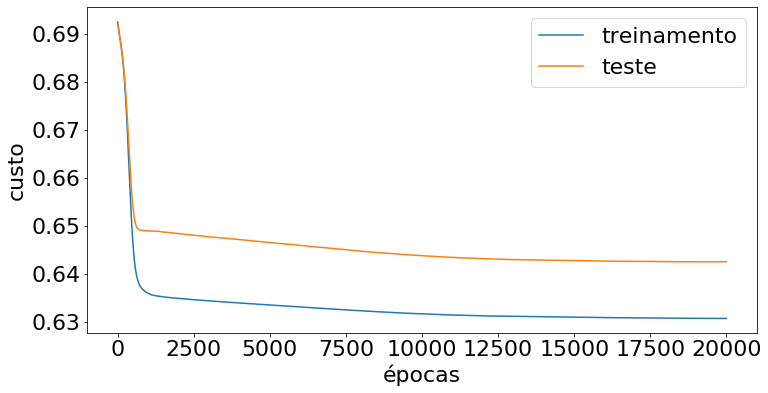

In [87]:
plt.figure(figsize=(12,6))
plt.plot(historia_custo)
plt.plot(historia_custo_teste)
plt.legend(['treinamento','teste'])
plt.ylabel('custo')
plt.xlabel('épocas')

In [66]:
y_pred,_ = propaga_total(np.transpose(X_test),valores_parametros,arquitetura)

Text(0.5, 0, 'temperatura')

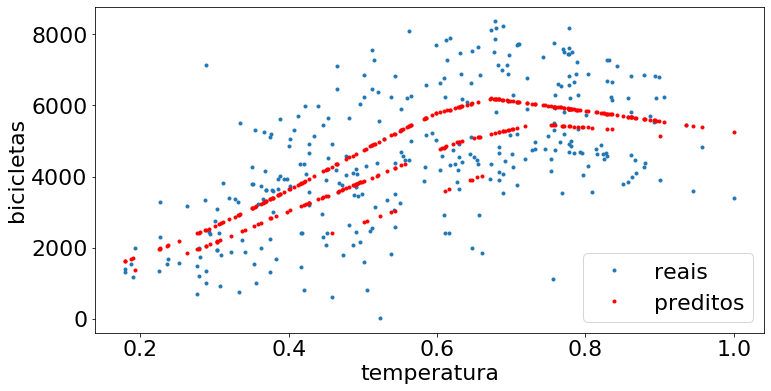

In [73]:
plt.figure(figsize=(12,6))
plt.plot(np.transpose(X_test)[1],ymax*y_test,'.')
plt.plot(np.transpose(X_test)[1],ymax*y_pred.reshape([-1,1]),'.r')
plt.legend(['reais','preditos'])
plt.ylabel('bicicletas Alugadas')
plt.xlabel('temperatura')

Text(0.5, 0, 'Clima')

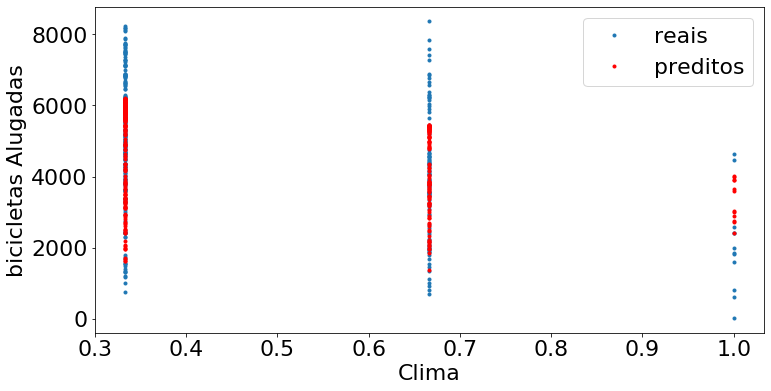

In [75]:
plt.figure(figsize=(12,6))
plt.plot(np.transpose(X_test)[0],ymax*y_test,'.')
plt.plot(np.transpose(X_test)[0],ymax*y_pred.reshape([-1,1]),'.r')
plt.legend(['reais','preditos'])
plt.ylabel('bicicletas Alugadas')
plt.xlabel('Clima')